# SCS_3666_018 Applied Natural Language Processing - Final Project
### Predicting ECB rate changes based on speeches leading up to monetary policy rate decision meetings

Speech data sourced from Kaggle:
https://www.kaggle.com/datasets/robertolofaro/ecb-speeches-1997-to-20191122-frequencies-dm

Rate change data sourced from ECB website: 
https://www.ecb.europa.eu/stats/policy_and_exchange_rates/key_ecb_interest_rates/html/index.en.html

##### Jonathan Fu

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import datetime

# import historical data for ECB meetings, decisions and rates
ECB_rate_decisions = pd.read_csv('ECB Decision Dates & Rate Changes.csv')

'''
def categorize_change(x):
    if x > 0:
        return "Increase"
    elif x < 0:
        return "Decrease"
    else:
        return "No change"

ECB_rate_decisions['Decision Direction'] = ECB_rate_decisions['Change (%)'].apply(categorize_change)
'''

# sort the dataframe by date
ECB_rate_decisions['Meeting Dates'] = pd.to_datetime(ECB_rate_decisions['Meeting Dates'], format='mixed',  errors='coerce')
ECB_rate_decisions = ECB_rate_decisions.sort_values(by='Meeting Dates').reset_index(drop=True)
ECB_rate_decisions

,Meeting Dates,Rate Change Date,Main refinancing operations - fixed rate tenders,Change (%),Direction
0,1999-01-13,NaN,3.00,NaN,NaN
1,1999-02-04,NaN,3.00,0.00,No Change
2,1999-03-04,NaN,3.00,0.00,No Change
3,1999-04-08,4/9/99,2.50,-0.50,Decrease
4,1999-05-06,NaN,2.50,0.00,No Change
...,...,...,...,...,...
245,2024-04-25,NaN,4.50,0.00,No Change
246,2024-06-06,6/12/24,4.25,-0.25,Decrease
247,2024-07-25,NaN,4.25,0.00,No Change
248,2024-09-05,9/18/24,3.65,-0.60,Decrease


In [2]:
Kaggle_ECB = pd.read_csv('export_datamart.csv')

# only include english releases and text based releases, exclude PDF files
Kaggle_ECB_eng = Kaggle_ECB.loc[Kaggle_ECB['what_language'].isin(['EN'])]
Kaggle_ECB_eng = Kaggle_ECB_eng[~Kaggle_ECB_eng['what_weblink'].str.contains('pdf')] # exclude links containing 'pdf'
Kaggle_ECB_eng = Kaggle_ECB_eng[~Kaggle_ECB_eng['what_weblink'].str.contains('.de.')] # remove links that contain '.de.' for non-english

# ECB was formed on Mar 1, 1999 - exclude all speeches before then
Kaggle_ECB_eng['when_speech'] = pd.to_datetime(Kaggle_ECB_eng['when_speech'], format='%m/%d/%Y')
Kaggle_ECB_eng = Kaggle_ECB_eng[~(Kaggle_ECB_eng['when_speech'] < '03/01/1999')]

# sort the dataframe by date
Kaggle_ECB_eng = Kaggle_ECB_eng.sort_values(by='when_speech').reset_index(drop=True)

In [3]:
Kaggle_ECB_eng

,speech_id,when_speech,who,what_title,what_frequencies,what_language,what_weblink,what_type
0,2748,1999-03-04,Willem F. Duisenberg,Introductory statement with Q&A,"{""euro"":45,""question"":33,""rate"":30,""duisenberg...",EN,https://www.ecb.europa.eu/press/pressconf/1999...,P
1,80,1999-03-08,Christian Noyer,First experiences with the euro,"{""monetary"":64,""euro"":51,""price"":48,""policy"":4...",EN,https://www.ecb.europa.eu/press/key/date/1999/...,S
2,81,1999-03-09,Tommaso Padoa-Schioppa,The euro: significance for Europe and beyond,"{""euro"":29,""currency"":20,""monetary"":15,""single...",EN,https://www.ecb.europa.eu/press/key/date/1999/...,S
3,82,1999-03-10,Eugenio Domingo Solans,The euro as a new world currency,"{""euro"":63,""currency"":29,""area"":23,""monetary"":...",EN,https://www.ecb.europa.eu/press/key/date/1999/...,S
4,83,1999-03-12,Willem F. Duisenberg,The Eurosystem's strategy for the euro,"{""monetary"":50,""stability"":35,""policy"":35,""pri...",EN,https://www.ecb.europa.eu/press/key/date/1999/...,S
...,...,...,...,...,...,...,...,...
3430,4710,2024-10-16,Christine Lagarde,Lessons from Ljubljana in uncertain times,"{""slovenia"":22,""europe"":11,""european"":6,""econo...",EN,https://www.ecb.europa.eu/press/key/date/2024/...,S
3431,4711,2024-10-17,"Christine Lagarde,\nLuis de Guindos",PRESS CONFERENCE,"{""inflation"":70,""data"":30,""policy"":23,""rate"":2...",EN,https://www.ecb.europa.eu/press/press_conferen...,P
3432,4718,2024-10-24,Matthias Rumpf,Cross-border deposits: growing trust in the eu...,"{""deposits"":21,""euro"":15,""area"":14,""countries""...",EN,https://www.ecb.europa.eu/press/blog/date/2024...,B
3433,4715,2024-10-24,Philip R. Lane,Underlying inflation: an update,"{""ecb"":2,""speech"":1,""dynamics"":1,""bank"":1,""res...",EN,https://www.ecb.europa.eu/press/key/date/2024/...,S


In [4]:
# merge the ECB speech/press release dataframe with the ECB meeting date & rate decision dataframe
# create temp column to match meetings that occured after speech/press release dates
joined = pd.merge_asof(Kaggle_ECB_eng, ECB_rate_decisions, left_on=['when_speech'], right_on='Meeting Dates', direction='forward')
joined['is_col2_earlier'] = joined['when_speech'] > joined['Meeting Dates']
joined['same_date'] = joined['when_speech'] == joined['Meeting Dates']
joined = joined.dropna(subset=['Direction'])
joined

,speech_id,when_speech,who,what_title,what_frequencies,what_language,what_weblink,what_type,Meeting Dates,Rate Change Date,Main refinancing operations - fixed rate tenders,Change (%),Direction,is_col2_earlier,same_date
0,2748,1999-03-04,Willem F. Duisenberg,Introductory statement with Q&A,"{""euro"":45,""question"":33,""rate"":30,""duisenberg...",EN,https://www.ecb.europa.eu/press/pressconf/1999...,P,1999-03-04,NaN,3.0,0.00,No Change,False,True
1,80,1999-03-08,Christian Noyer,First experiences with the euro,"{""monetary"":64,""euro"":51,""price"":48,""policy"":4...",EN,https://www.ecb.europa.eu/press/key/date/1999/...,S,1999-04-08,4/9/99,2.5,-0.50,Decrease,False,False
2,81,1999-03-09,Tommaso Padoa-Schioppa,The euro: significance for Europe and beyond,"{""euro"":29,""currency"":20,""monetary"":15,""single...",EN,https://www.ecb.europa.eu/press/key/date/1999/...,S,1999-04-08,4/9/99,2.5,-0.50,Decrease,False,False
3,82,1999-03-10,Eugenio Domingo Solans,The euro as a new world currency,"{""euro"":63,""currency"":29,""area"":23,""monetary"":...",EN,https://www.ecb.europa.eu/press/key/date/1999/...,S,1999-04-08,4/9/99,2.5,-0.50,Decrease,False,False
4,83,1999-03-12,Willem F. Duisenberg,The Eurosystem's strategy for the euro,"{""monetary"":50,""stability"":35,""policy"":35,""pri...",EN,https://www.ecb.europa.eu/press/key/date/1999/...,S,1999-04-08,4/9/99,2.5,-0.50,Decrease,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3429,4709,2024-10-09,"Dennis Essers, Laura Lebastard, Michele Manci...",Critical inputs from China: how vulnerable are...,"{""countries"":22,""added"":15,""supply"":12,""chart""...",EN,https://www.ecb.europa.eu/press/blog/date/2024...,B,2024-10-24,10/23/24,3.4,-0.25,Decrease,False,False
3430,4710,2024-10-16,Christine Lagarde,Lessons from Ljubljana in uncertain times,"{""slovenia"":22,""europe"":11,""european"":6,""econo...",EN,https://www.ecb.europa.eu/press/key/date/2024/...,S,2024-10-24,10/23/24,3.4,-0.25,Decrease,False,False
3431,4711,2024-10-17,"Christine Lagarde,\nLuis de Guindos",PRESS CONFERENCE,"{""inflation"":70,""data"":30,""policy"":23,""rate"":2...",EN,https://www.ecb.europa.eu/press/press_conferen...,P,2024-10-24,10/23/24,3.4,-0.25,Decrease,False,False
3432,4718,2024-10-24,Matthias Rumpf,Cross-border deposits: growing trust in the eu...,"{""deposits"":21,""euro"":15,""area"":14,""countries""...",EN,https://www.ecb.europa.eu/press/blog/date/2024...,B,2024-10-24,10/23/24,3.4,-0.25,Decrease,False,True


In [5]:
# count the number of interest rate directional changes
print(joined['Direction'].value_counts())

Direction
No Change    2888
Decrease      294
Increase      252
Name: count, dtype: int64


In [6]:
# create a separate dataframe to identify speeches or press releases that happened on the same day as policy meeting date
same_day_df = joined[joined['same_date'] == True]
same_day_df

,speech_id,when_speech,who,what_title,what_frequencies,what_language,what_weblink,what_type,Meeting Dates,Rate Change Date,Main refinancing operations - fixed rate tenders,Change (%),Direction,is_col2_earlier,same_date
0,2748,1999-03-04,Willem F. Duisenberg,Introductory statement with Q&A,"{""euro"":45,""question"":33,""rate"":30,""duisenberg...",EN,https://www.ecb.europa.eu/press/pressconf/1999...,P,1999-03-04,NaN,3.00,0.00,No Change,False,True
8,2749,1999-04-08,Willem F. Duisenberg,Introductory statement with Q&A,"{""euro"":39,""rate"":35,""today"":24,""interest"":22,...",EN,https://www.ecb.europa.eu/press/pressconf/1999...,P,1999-04-08,4/9/99,2.50,-0.50,Decrease,False,True
17,2750,1999-05-06,Willem F. Duisenberg,Introductory statement with Q&A,"{""euro"":29,""question"":17,""developments"":16,""ra...",EN,https://www.ecb.europa.eu/press/pressconf/1999...,P,1999-05-06,NaN,2.50,0.00,No Change,False,True
27,110,1999-06-03,Willem F. Duisenberg,Developments in the Financial Sector in Europe...,"{""markets"":40,""euro"":38,""area"":30,""financial"":...",EN,https://www.ecb.europa.eu/press/key/date/1999/...,S,1999-06-03,NaN,2.50,0.00,No Change,False,True
46,2753,1999-09-09,Willem F. Duisenberg,Introductory statement with Q&A,"{""monetary"":35,""question"":33,""year"":31,""euro"":...",EN,https://www.ecb.europa.eu/press/pressconf/1999...,P,1999-09-09,NaN,2.50,0.00,No Change,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3327,4549,2024-01-25,"Christine Lagarde, Luis de Guindos",PRESS CONFERENCE,"{""inflation"":49,""question"":25,""data"":25,""polic...",EN,https://www.ecb.europa.eu/press/pressconf/2024...,P,2024-01-25,NaN,4.50,0.00,No Change,False,True
3345,4582,2024-03-07,"Christine Lagarde,\nLuis de Guindos",PRESS CONFERENCE,"{""inflation"":63,""cent"":27,""growth"":20,""policy""...",EN,https://www.ecb.europa.eu/press/pressconf/2024...,P,2024-03-07,NaN,4.50,0.00,No Change,False,True
3379,4644,2024-06-06,"Christine Lagarde, Luis de Guindos",PRESS CONFERENCE,"{""inflation"":61,""data"":42,""cent"":28,""policy"":2...",EN,https://www.ecb.europa.eu/press/press_conferen...,P,2024-06-06,6/12/24,4.25,-0.25,Decrease,False,True
3432,4718,2024-10-24,Matthias Rumpf,Cross-border deposits: growing trust in the eu...,"{""deposits"":21,""euro"":15,""area"":14,""countries""...",EN,https://www.ecb.europa.eu/press/blog/date/2024...,B,2024-10-24,10/23/24,3.40,-0.25,Decrease,False,True


In [7]:
# count the number of interest rate directional changes
print(same_day_df['Direction'].value_counts())

Direction
No Change    208
Decrease      19
Increase      14
Name: count, dtype: int64


In [8]:
#Kaggle_ECB_eng['when_speech'].tolist()

In [9]:
print(Kaggle_ECB_eng.shape)

(3435, 8)


In [10]:
links = Kaggle_ECB_eng['what_weblink'].tolist()
links[0]

'https://www.ecb.europa.eu/press/pressconf/1999/html/is990304.en.html'

In [11]:
# screen scrape text data from ECB website

import requests
from bs4 import BeautifulSoup
from tqdm import tqdm

with tqdm(total=len(joined), desc="Processing links", unit="link") as pbar:
    for index, row in joined.iterrows():
        link = row['what_weblink']
        #print("Link:", link)
            
        page = requests.get(link, verify=True)
        soup = BeautifulSoup(page.content, "html.parser")
    
        # look for only content in the 'main section'
        main_content = soup.find('main')
    
        sections = []
        
        # extract plain text from body/section
        section_elements = main_content.find_all('div', class_='section')
        for section_element in section_elements:
            section_text = section_element.get_text(strip=True)
            sections.append(section_text)
            #print(section_text)
    
        article_text = " ".join(sections) # convert list into string before appending to articles list
        joined.at[index, 'extracted_text'] = article_text 

        pbar.update(1)
    

Processing links: 100%|███████████████████| 3434/3434 [31:13<00:00,  1.83link/s]


In [12]:
joined

,speech_id,when_speech,who,what_title,what_frequencies,what_language,what_weblink,what_type,Meeting Dates,Rate Change Date,Main refinancing operations - fixed rate tenders,Change (%),Direction,is_col2_earlier,same_date,extracted_text
0,2748,1999-03-04,Willem F. Duisenberg,Introductory statement with Q&A,"{""euro"":45,""question"":33,""rate"":30,""duisenberg...",EN,https://www.ecb.europa.eu/press/pressconf/1999...,P,1999-03-04,NaN,3.0,0.00,No Change,False,True,"Willem F. Duisenberg, President of the Europea..."
1,80,1999-03-08,Christian Noyer,First experiences with the euro,"{""monetary"":64,""euro"":51,""price"":48,""policy"":4...",EN,https://www.ecb.europa.eu/press/key/date/1999/...,S,1999-04-08,4/9/99,2.5,-0.50,Decrease,False,False,"Speech by Christian Noyer, Vice-President of t..."
2,81,1999-03-09,Tommaso Padoa-Schioppa,The euro: significance for Europe and beyond,"{""euro"":29,""currency"":20,""monetary"":15,""single...",EN,https://www.ecb.europa.eu/press/key/date/1999/...,S,1999-04-08,4/9/99,2.5,-0.50,Decrease,False,False,Speech by Tommaso Padoa-Schioppa Member of the...
3,82,1999-03-10,Eugenio Domingo Solans,The euro as a new world currency,"{""euro"":63,""currency"":29,""area"":23,""monetary"":...",EN,https://www.ecb.europa.eu/press/key/date/1999/...,S,1999-04-08,4/9/99,2.5,-0.50,Decrease,False,False,"Eugenio Domingo Solans, Member of the Executiv..."
4,83,1999-03-12,Willem F. Duisenberg,The Eurosystem's strategy for the euro,"{""monetary"":50,""stability"":35,""policy"":35,""pri...",EN,https://www.ecb.europa.eu/press/key/date/1999/...,S,1999-04-08,4/9/99,2.5,-0.50,Decrease,False,False,"Speech by Dr. Willem F. Duisenberg, President ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3429,4709,2024-10-09,"Dennis Essers, Laura Lebastard, Michele Manci...",Critical inputs from China: how vulnerable are...,"{""countries"":22,""added"":15,""supply"":12,""chart""...",EN,https://www.ecb.europa.eu/press/blog/date/2024...,B,2024-10-24,10/23/24,3.4,-0.25,Decrease,False,False,"9 October 2024By Dennis Essers, Laura Lebastar..."
3430,4710,2024-10-16,Christine Lagarde,Lessons from Ljubljana in uncertain times,"{""slovenia"":22,""europe"":11,""european"":6,""econo...",EN,https://www.ecb.europa.eu/press/key/date/2024/...,S,2024-10-24,10/23/24,3.4,-0.25,Decrease,False,False,"Speech by Christine Lagarde, President of the ..."
3431,4711,2024-10-17,"Christine Lagarde,\nLuis de Guindos",PRESS CONFERENCE,"{""inflation"":70,""data"":30,""policy"":23,""rate"":2...",EN,https://www.ecb.europa.eu/press/press_conferen...,P,2024-10-24,10/23/24,3.4,-0.25,Decrease,False,False,"Christine Lagarde, President of the ECB,Luis d..."
3432,4718,2024-10-24,Matthias Rumpf,Cross-border deposits: growing trust in the eu...,"{""deposits"":21,""euro"":15,""area"":14,""countries""...",EN,https://www.ecb.europa.eu/press/blog/date/2024...,B,2024-10-24,10/23/24,3.4,-0.25,Decrease,False,True,24 October 2024 [Paragraph five and six of th...


In [13]:
dates = joined['when_speech'].tolist()
titles = joined['what_title'].tolist()
print(len(dates))
print(len(titles))

3434
3434


In [14]:
articles = joined['extracted_text'].tolist()

In [15]:
len(articles)

3434

In [16]:
# ensure all lists have the same length before joining as dictionary/json file
assert len(dates) == len(titles) == len(articles), "All lists must have the same length"

In [17]:
# check first item in dictionary called data
#data[0]
#data[0]["content"]

In [18]:
# check articles first item in list
#articles[0]

In [19]:
# check to ensure all articles are individual strings in the list
for index, article in enumerate(articles):
    if not isinstance(article, str):
        print(f"Element {index} is not a string.")

## Exploratory Data Analysis

### Text Normalizer

In [20]:
import nltk
from nltk import word_tokenize, pos_tag
import unicodedata
import numpy as np
import re

from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.base import BaseEstimator, TransformerMixin

class TextNormalizer(BaseEstimator, TransformerMixin):

    def __init__(self, language='english'):
        self.language = language
        self.stopwords  = set(nltk.corpus.stopwords.words(language))
        self.lemmatizer = WordNetLemmatizer()

    def is_punct(self, token):
        return all(
            unicodedata.category(char).startswith('P') for char in token
        )

    def is_stopword(self, token):
        return token.lower() in self.stopwords

    def normalize(self, document):
        tagged_tokens = pos_tag(word_tokenize(document))  # Tokenize and tag
        normalized_text = [
            self.lemmatize(re.sub(r'\W+', '', token), tag).lower()
            for token, tag in tagged_tokens
            if not self.is_punct(token) and not self.is_stopword(token)
        ]
        #print("Normalized text:", " ".join(normalized_text))
        return normalized_text

    def lemmatize(self, token, pos_tag):
        tag = {
            'N': wn.NOUN,
            'V': wn.VERB,
            'R': wn.ADV,
            'J': wn.ADJ
        }.get(pos_tag[0], wn.NOUN)

        return self.lemmatizer.lemmatize(token, tag)

    def fit(self, X, y=None):
        return self

    def transform(self, documents):
        return [self.normalize(document) for document in tqdm(documents, desc="Normalizing Documents")]

In [21]:
normalizer = TextNormalizer()
normalized_speeches = normalizer.transform(articles)

Normalizing Documents: 100%|████████████████| 3434/3434 [02:38<00:00, 21.69it/s]


In [22]:
#print(normalized_speeches[0])

In [23]:
normalized_speeches_join = [" ".join(tokens) for tokens in normalized_speeches]
#normalized_speeches_join[:1]

### Frequency distribution of the corpus after stopwords removal

In [24]:
#!pip install yellowbrick

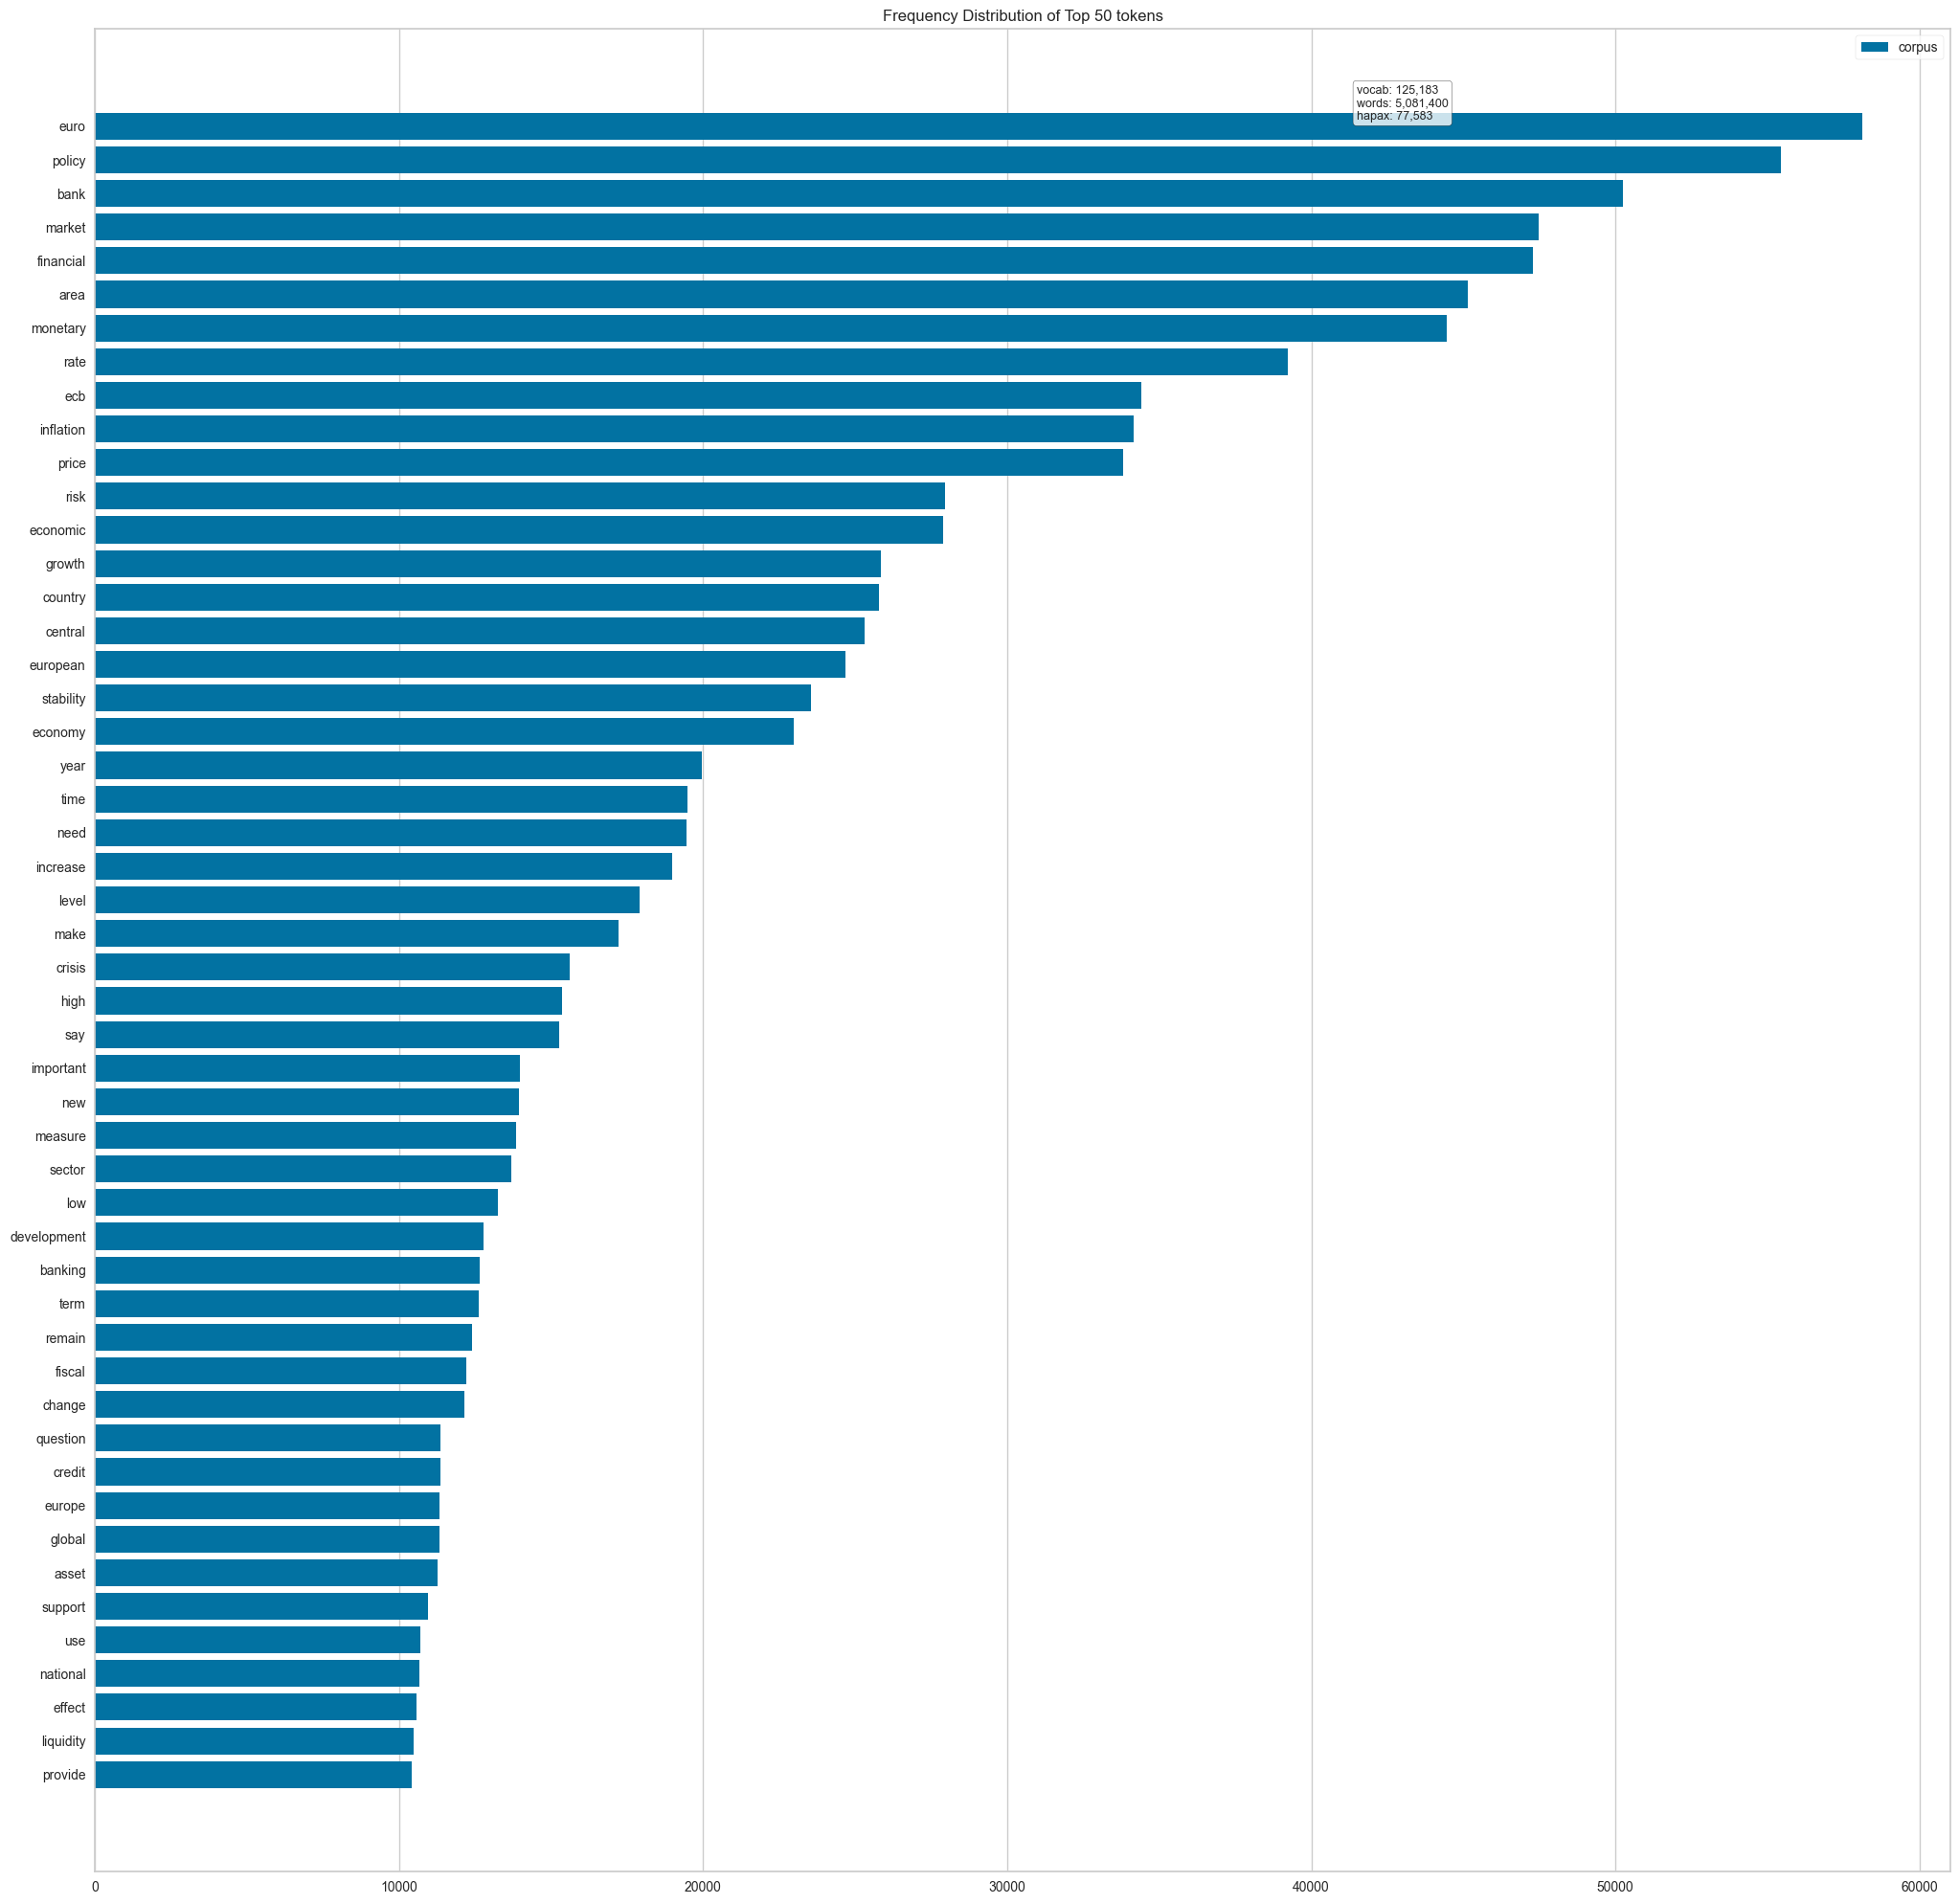

CPU times: user 2.61 s, sys: 2.05 s, total: 4.66 s
Wall time: 2.47 s


In [25]:
%%time
from yellowbrick.text.freqdist import FreqDistVisualizer
from sklearn.feature_extraction.text import CountVectorizer

# Join all speeches together into one string
all_speechs_one_list = [' '.join(doc) for doc in normalized_speeches]

def freq_distribution(data):
    # Visualize frequency distribution of top 50 tokens
    vectorizer = CountVectorizer(stop_words = 'english')
    docs = vectorizer.fit_transform(data)
    features = vectorizer.get_feature_names_out()
    
    plt.figure(figsize=(25,25), facecolor='white')
    visualizer = FreqDistVisualizer(features)
    visualizer.fit(docs)
    visualizer.poof()

freq_distribution(all_speechs_one_list)

### Gensim LDA visualization

In [26]:
%%time
from sklearn.base import BaseEstimator, TransformerMixin
from gensim.models import TfidfModel, LdaModel
from gensim.corpora import Dictionary
from sklearn.pipeline import Pipeline

# Ensure documents are tokenized
tokenized_docs = [doc.split() for doc in normalized_speeches_join]

class GensimTfidfVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, dirpath=".", tofull=False):
        self._lexicon_path = os.path.join(dirpath, "corpus.dict")
        self._tfidf_path = os.path.join(dirpath, "tfidf.model")
        self.lexicon = None
        self.tfidf = None
        self.tofull = tofull
        self.load()

    def load(self):
        if os.path.exists(self._lexicon_path):
            self.lexicon = Dictionary.load(self._lexicon_path)
        if os.path.exists(self._tfidf_path):
            self.tfidf = TfidfModel.load(self._tfidf_path)

    def save(self):
        self.lexicon.save(self._lexicon_path)
        self.tfidf.save(self._tfidf_path)

    def fit(self, documents, labels=None):
        self.lexicon = Dictionary(documents)
        self.tfidf = TfidfModel([self.lexicon.doc2bow(doc) for doc in documents], id2word=self.lexicon)
        self.save()
        return self

    def transform(self, documents):
        return [self.tfidf[self.lexicon.doc2bow(doc)] for doc in documents]

class GensimLdaModel:
    def __init__(self, n_topics=50):
        self.n_topics = n_topics
        self.model = None

    def fit(self, tfidf_corpus, id2word):
        self.model = LdaModel(tfidf_corpus, num_topics=self.n_topics, id2word=id2word)
        return self

    def transform(self, tfidf_corpus):
        return [self.model[doc] for doc in tfidf_corpus]

class GensimTopicModels:
    def __init__(self, n_topics=50):
        self.n_topics = n_topics
        self.pipeline = Pipeline([
            # ('norm', TextNormalizer(output="list")),  # Add normalizer if required
            ('vect', GensimTfidfVectorizer()),
            ('lda', GensimLdaModel(n_topics=n_topics))
        ])

    def fit(self, documents):
        vectorized_docs = self.pipeline.named_steps['vect'].fit_transform(documents)
        self.pipeline.named_steps['lda'].fit(vectorized_docs, self.pipeline.named_steps['vect'].lexicon)
        return self.pipeline

    def show_topics(self, num_words=10):
        lda_model = self.pipeline.named_steps['lda'].model
        return lda_model.show_topics(num_words=num_words)

# Fit the model
topic_model_gensim = GensimTopicModels(n_topics=3)
topic_model_gensim.fit(tokenized_docs)

# View topics
print(topic_model_gensim.show_topics())

[(0, '0.000*"s" + 0.000*"integration" + 0.000*"currency" + 0.000*"exchange" + 0.000*"inflation" + 0.000*"price" + 0.000*"fiscal" + 0.000*"rate" + 0.000*"crisis" + 0.000*"payment"'), (1, '0.000*"integration" + 0.000*"duisenberg" + 0.000*"currency" + 0.000*"reform" + 0.000*"trichet" + 0.000*"inflation" + 0.000*"s" + 0.000*"mr" + 0.000*"supervisory" + 0.000*"exchange"'), (2, '0.001*"inflation" + 0.001*"digital" + 0.001*"pandemic" + 0.001*"climate" + 0.001*"s" + 0.001*"purchase" + 0.001*"payment" + 0.001*"rate" + 0.001*"energy" + 0.001*"chart"')]
CPU times: user 9.39 s, sys: 112 ms, total: 9.5 s
Wall time: 9.69 s


In [27]:
%%time
import pyLDAvis
import pyLDAvis.gensim

# Getting the fitted LDA Model object from the Pipeline
gensim_model = topic_model_gensim.pipeline.named_steps['lda'].model

# Getting the Vectorized documents
vectorized_corpus = [
    topic_model_gensim.pipeline.named_steps['vect'].lexicon.doc2bow(doc)
    for doc in tokenized_docs
]

# Building the dictionary
lexicon = topic_model_gensim.pipeline.named_steps['vect'].lexicon

# Creating pyLDAvis model on the input data
data = pyLDAvis.gensim.prepare(gensim_model, vectorized_corpus, lexicon)

'''Use below code to save the visualization as an html file inside your desired
   local directory or google drive'''
pyLDAvis.save_html(data, 'gensim_model.html')

# Use below code to showing the visualization inside Jupyter notebook
display(pyLDAvis.display(data))

/opt/miniconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=1415) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/miniconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=1415) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/miniconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=1415) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/miniconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=1415) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/miniconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarni

CPU times: user 2.22 s, sys: 150 ms, total: 2.37 s
Wall time: 3.59 s


### K-Means Clustering

/opt/miniconda3/lib/python3.12/site-packages/yellowbrick/text/tsne.py:401: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  self.ax.scatter(
/opt/miniconda3/lib/python3.12/site-packages/yellowbrick/base.py:258: DeprecationWarning: this method is deprecated, please use show() instead
  warnings.warn(


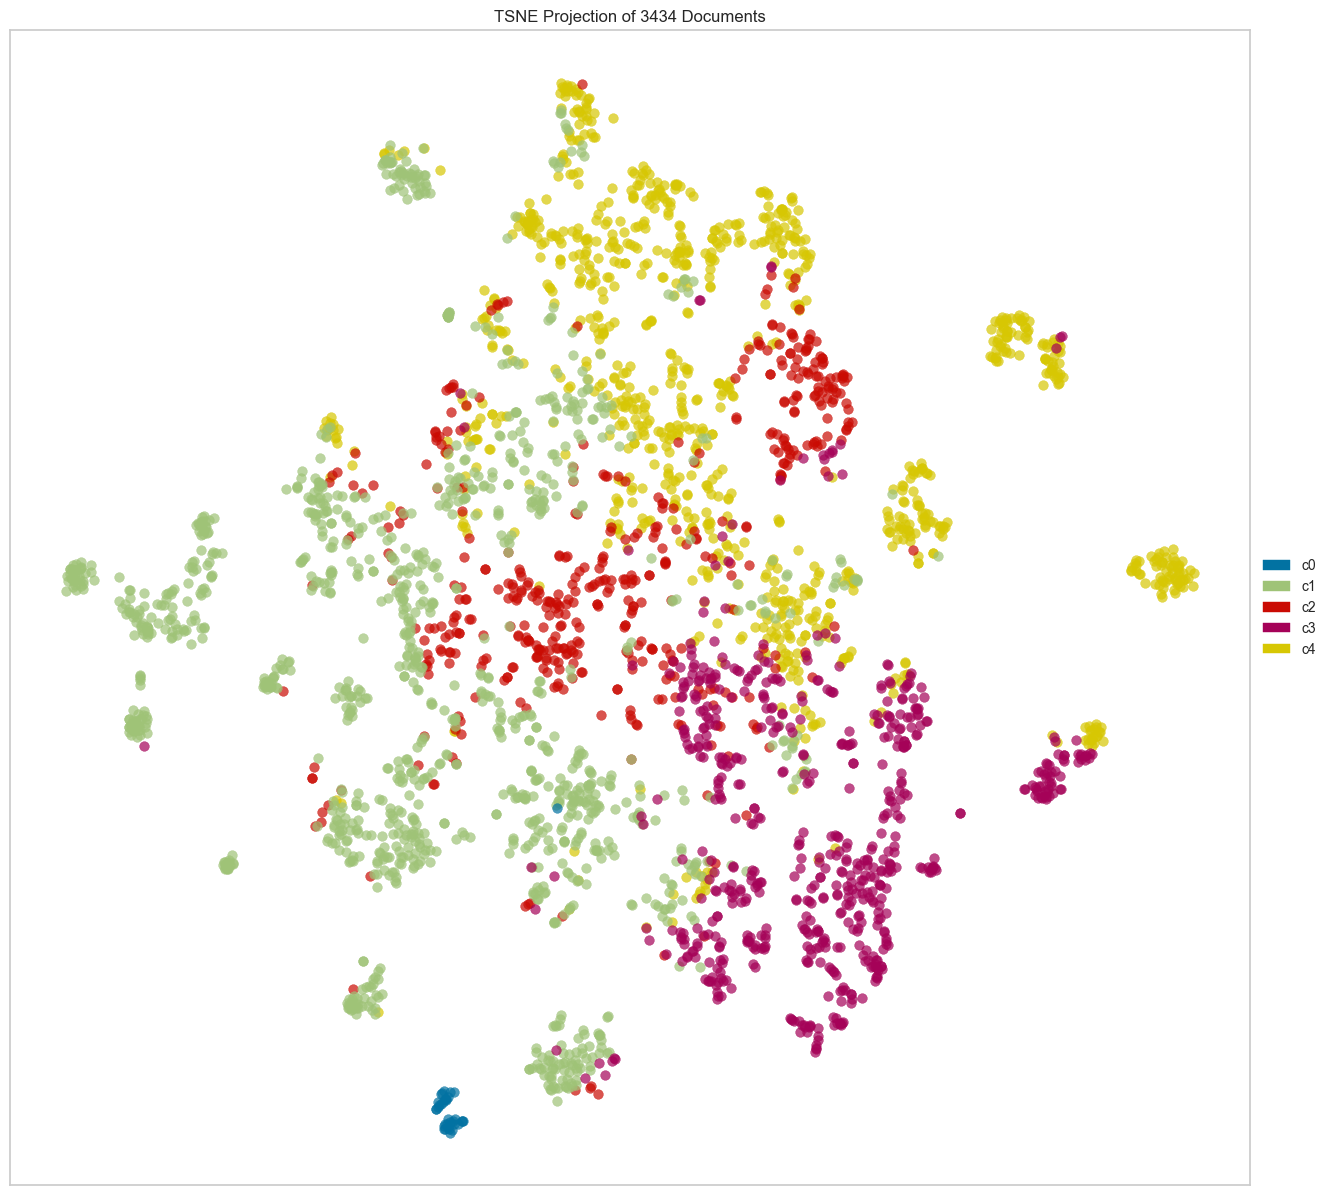

CPU times: user 1min 13s, sys: 29.2 s, total: 1min 42s
Wall time: 12.3 s


<Axes: title={'center': 'TSNE Projection of 3434 Documents'}>

In [28]:
%%time
from sklearn.cluster import KMeans
from yellowbrick.text import TSNEVisualizer
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
docs = tfidf.fit_transform(all_speechs_one_list)

# Applying k-means clustering
clusters = KMeans(n_clusters=5)
clusters.fit(docs)
# Applying t-SNE visualization
plt.figure(figsize=(20,15))
tsne = TSNEVisualizer()
tsne.fit(docs, ["c{}".format(c) for c in clusters.labels_])
tsne.poof()

/opt/miniconda3/lib/python3.12/site-packages/yellowbrick/base.py:258: DeprecationWarning: this method is deprecated, please use show() instead
  warnings.warn(


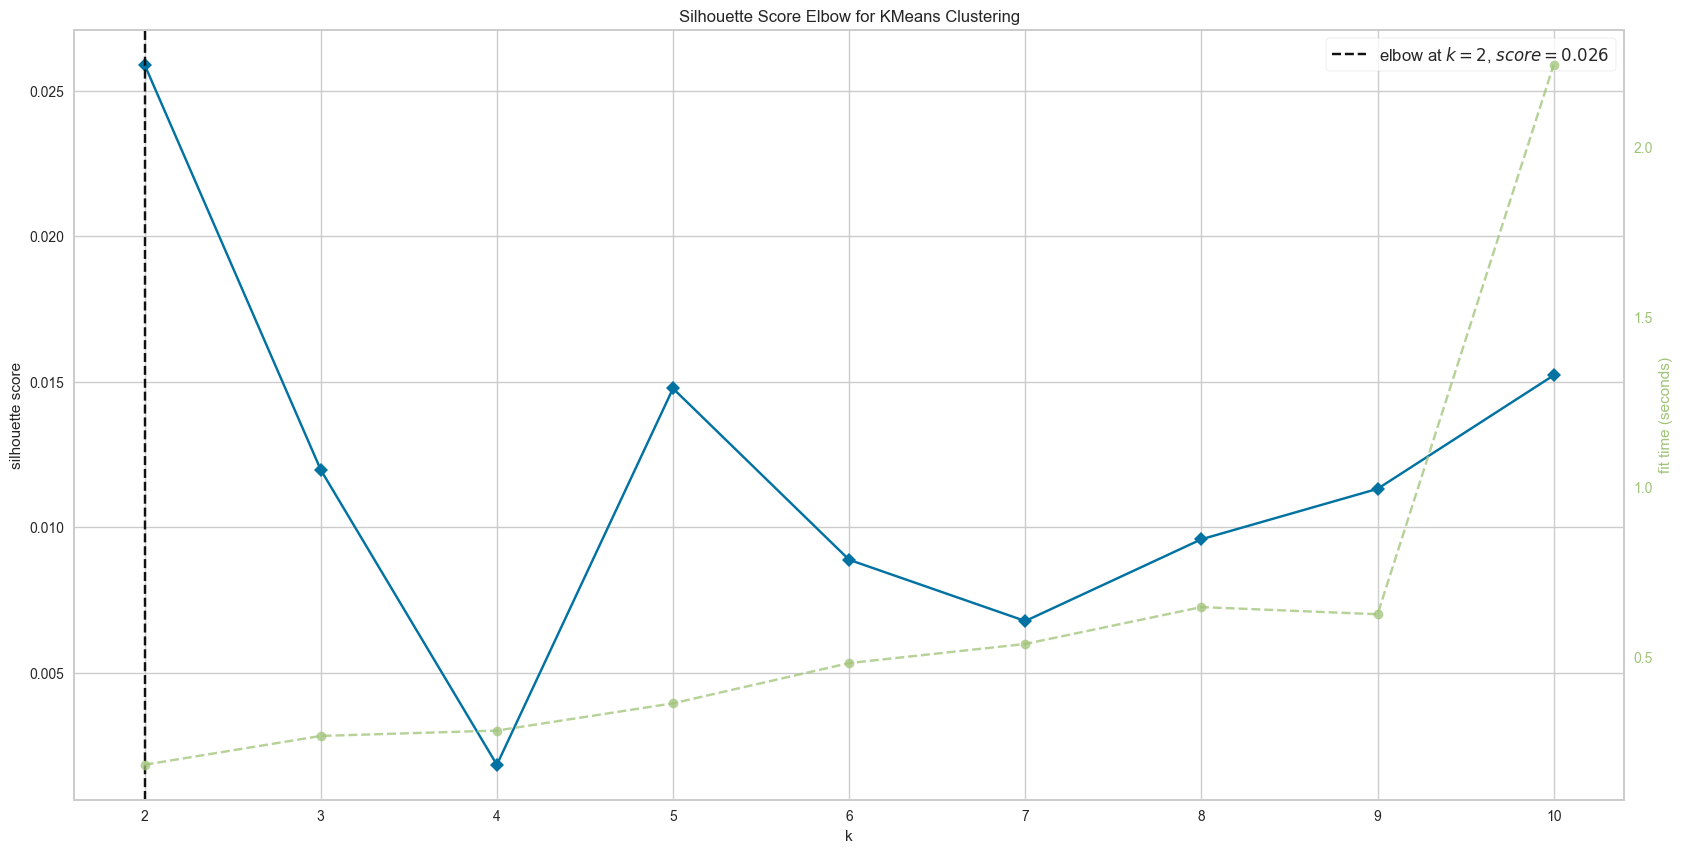

CPU times: user 1min 4s, sys: 23.4 s, total: 1min 28s
Wall time: 29.7 s


<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [29]:
%%time
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
plt.figure(figsize=(20,10))
visualizer = KElbowVisualizer(KMeans(), metric='silhouette', k=list(range(2,11)))
visualizer.fit(docs)
visualizer.poof()

/opt/miniconda3/lib/python3.12/site-packages/yellowbrick/style/colors.py:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap(colormap)
/opt/miniconda3/lib/python3.12/site-packages/yellowbrick/base.py:258: DeprecationWarning: this method is deprecated, please use show() instead
  warnings.warn(


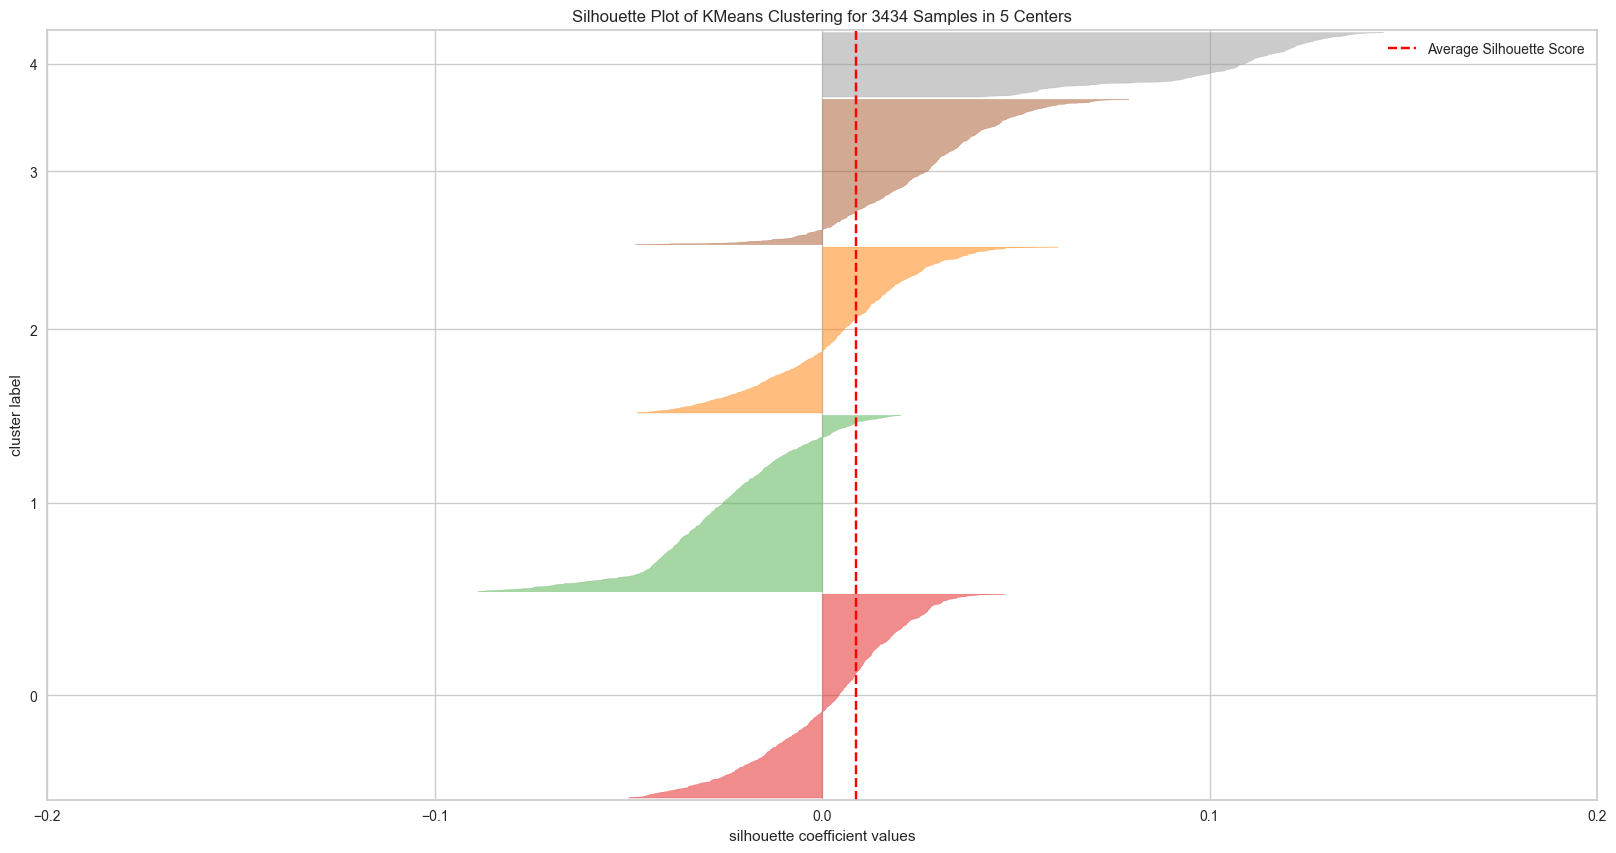

CPU times: user 11.1 s, sys: 2.93 s, total: 14.1 s
Wall time: 6.15 s


<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 3434 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [30]:
%%time
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer

# Instantiate the clustering model and visualizer
plt.figure(figsize=(20,10))
visualizer = SilhouetteVisualizer(KMeans(n_clusters=5))
visualizer.fit(docs)
visualizer.poof()

In [31]:
%%time
from nltk.cluster import KMeansClusterer
from sklearn.base import BaseEstimator, TransformerMixin

class KMeansClusters(BaseEstimator, TransformerMixin):
    def __init__(self, k=7):
        """
        k is the number of clusters model is the implementation of Kmeans
        """
        self.k = k
        self.distance = nltk.cluster.util.cosine_distance
        self.model = KMeansClusterer(self.k, self.distance, avoid_empty_clusters=True)

    def fit(self, documents, labels=None):
        return self

    def transform(self, documents):
        """
        Fits the K-Means model to one-hot vectorized documents.
        """
        return self.model.cluster(documents, assign_clusters=True)

CPU times: user 1.32 ms, sys: 22 μs, total: 1.34 ms
Wall time: 121 μs


In [32]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer

class OneHotVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.vectorizer = CountVectorizer(binary=True)

    def fit(self, documents, labels=None):
        return self

    def transform(self, documents):
        freqs = self.vectorizer.fit_transform(documents)
        return [freq.toarray()[0] for freq in freqs]

In [33]:
from sklearn.pipeline import Pipeline

model = Pipeline([
        #('norm', TextNormalizer()),
        ('vect', OneHotVectorizer()),
        ('clusters', KMeansClusters(k=3))
        ])

clusters = model.fit_transform(normalized_speeches_join)

#for idx, cluster in enumerate(clusters):
#    print("Document '{}' assigned to cluster {}.".format(pickles[idx],cluster))

/opt/miniconda3/lib/python3.12/site-packages/nltk/cluster/util.py:130: RuntimeWarning: invalid value encountered in divide
  return 1 - (numpy.dot(u, v) / (sqrt(numpy.dot(u, u)) * sqrt(numpy.dot(v, v))))
/opt/miniconda3/lib/python3.12/site-packages/nltk/cluster/util.py:130: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - (numpy.dot(u, v) / (sqrt(numpy.dot(u, u)) * sqrt(numpy.dot(v, v))))


In [34]:
from collections import Counter

cluster_counts = Counter(clusters)
print("\nNumber of documents in each cluster:")
for cluster_id, count in cluster_counts.items():
    print(f"Cluster {cluster_id}: {count} documents")


Number of documents in each cluster:
Cluster 0: 1301 documents
Cluster 2: 1111 documents
Cluster 1: 1022 documents


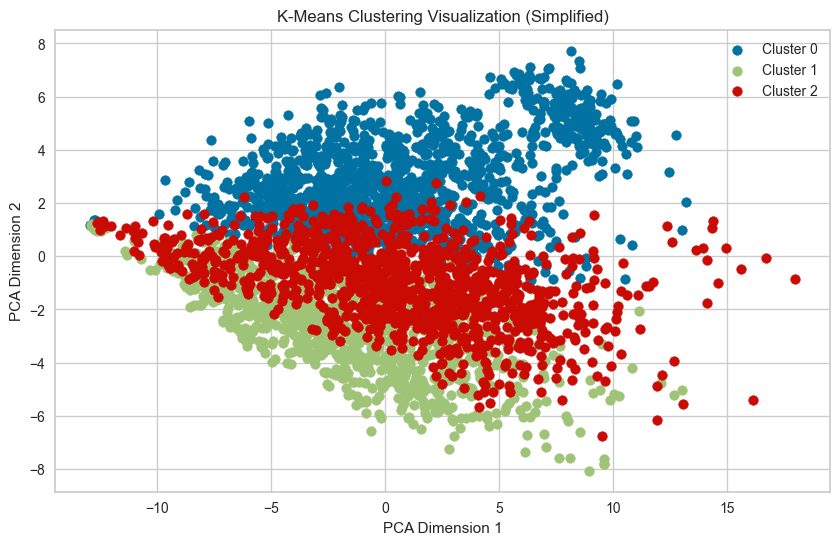

In [35]:
# plot K-means clusters
from sklearn.decomposition import PCA

vectorized_documents = model.named_steps['vect'].vectorizer.fit_transform(normalized_speeches_join).toarray()

pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(vectorized_documents)

cluster_assignments = clusters

plt.figure(figsize=(10, 6))
for cluster_id in np.unique(cluster_assignments):
    cluster_points = reduced_vectors[np.array(cluster_assignments) == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_id}")

plt.title("K-Means Clustering Visualization (Simplified)")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.legend()
plt.show()

### N-Gram analysis

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.pipeline import make_pipeline
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

stopwords_list = stopwords.words('english')

# Create a TF-IDF vectorizer object
# TF-IDF (Term Frequency-Inverse Document Frequency) is a technique used to quantify a word in documents
# It is used to reflect how important a word is to a document in a collection or corpus
# The stop_words parameter is used to ignore common words in English such as 'this', 'is', etc.
# The ngram_range parameter is used to specify the size of word chunks to consider as features
tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords_list, ngram_range=(2,5))

# Create an NMF (Non-Negative Matrix Factorization) object
# The n_components parameter is used to specify the number of topics to extract
nmf = NMF(n_components=3)

# Create a pipeline object that sequentially applies the TF-IDF vectorizer and NMF
pipe = make_pipeline(tfidf_vectorizer, nmf)

def plot_top_words(model, feature_names, n_top_words):
    fig, axes = plt.subplots(1, 3, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

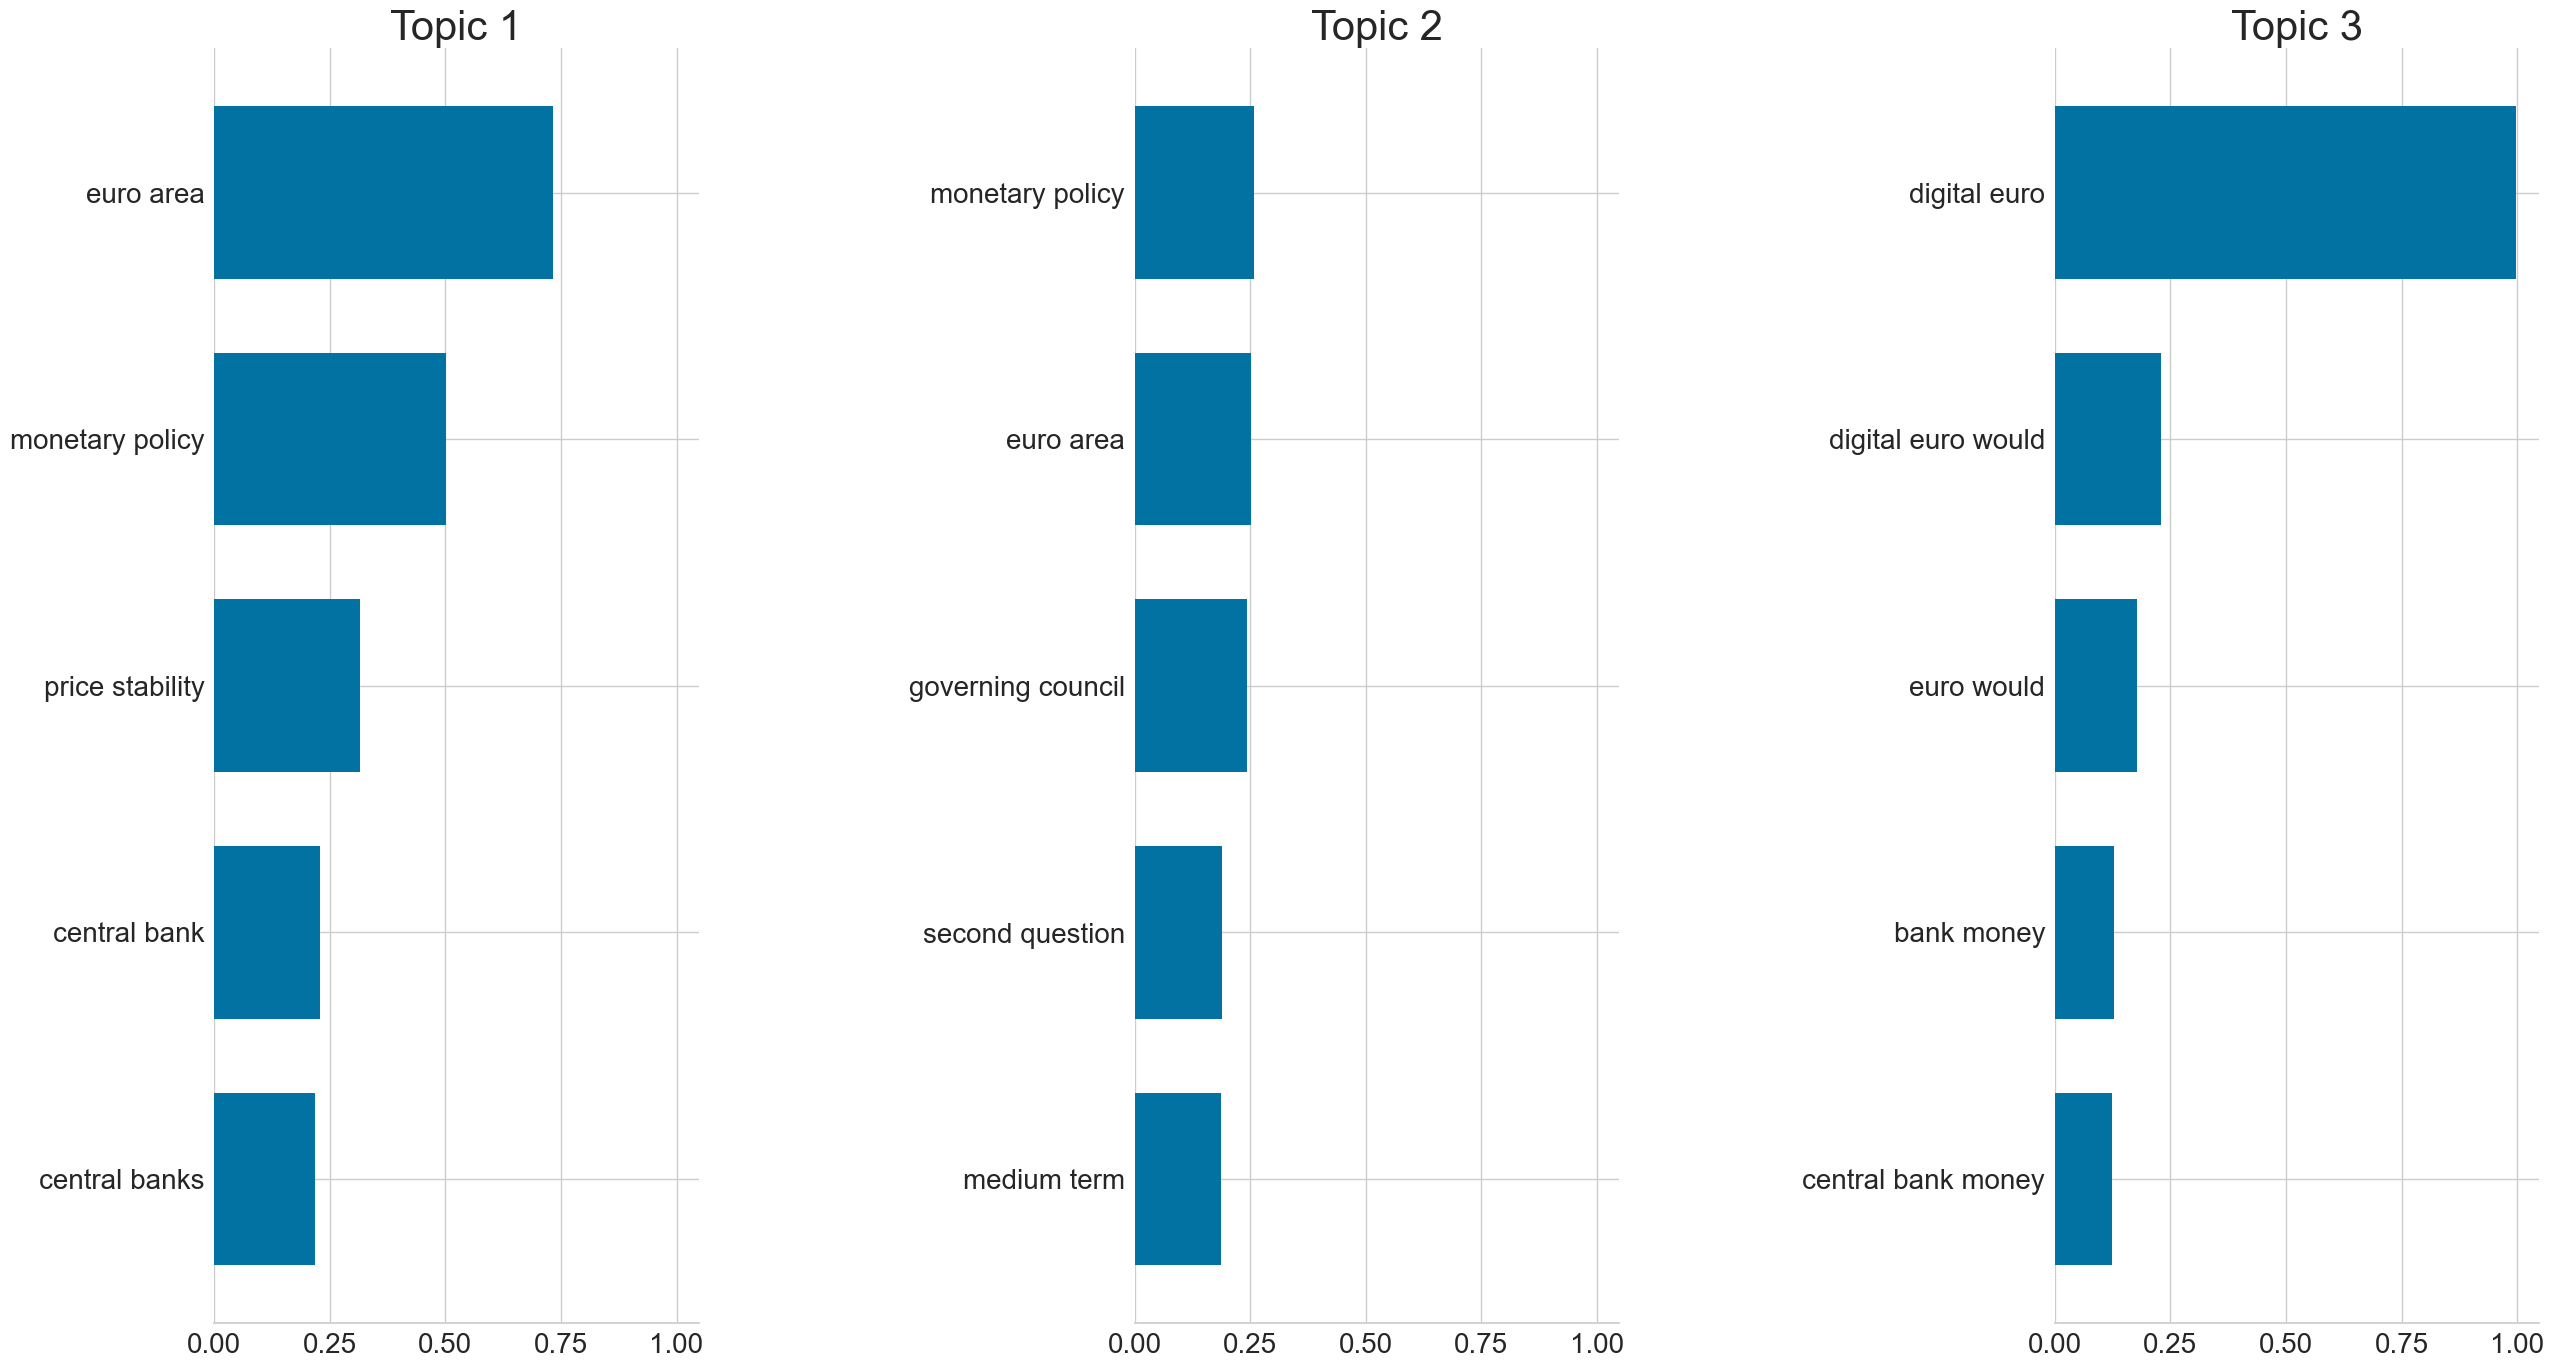

CPU times: user 2min 59s, sys: 59.2 s, total: 3min 59s
Wall time: 2min 35s


In [37]:
%%time
def NMF_fit(data):
    pipe.fit(data)
    
    # Plot the top words in the topics identified by the NMF model
    plot_top_words(
        nmf, tfidf_vectorizer.get_feature_names_out(), 5
    )

NMF_fit(joined['extracted_text'].dropna().astype(str))

### Deep dive into Speeches & Press releases preceeding a rate change

In [38]:
direction_increase_df = joined[joined['Direction'] == 'Increase']
direction_decrease_df = joined[joined['Direction'] == 'Decrease']

/opt/miniconda3/lib/python3.12/site-packages/yellowbrick/base.py:258: DeprecationWarning: this method is deprecated, please use show() instead
  warnings.warn(


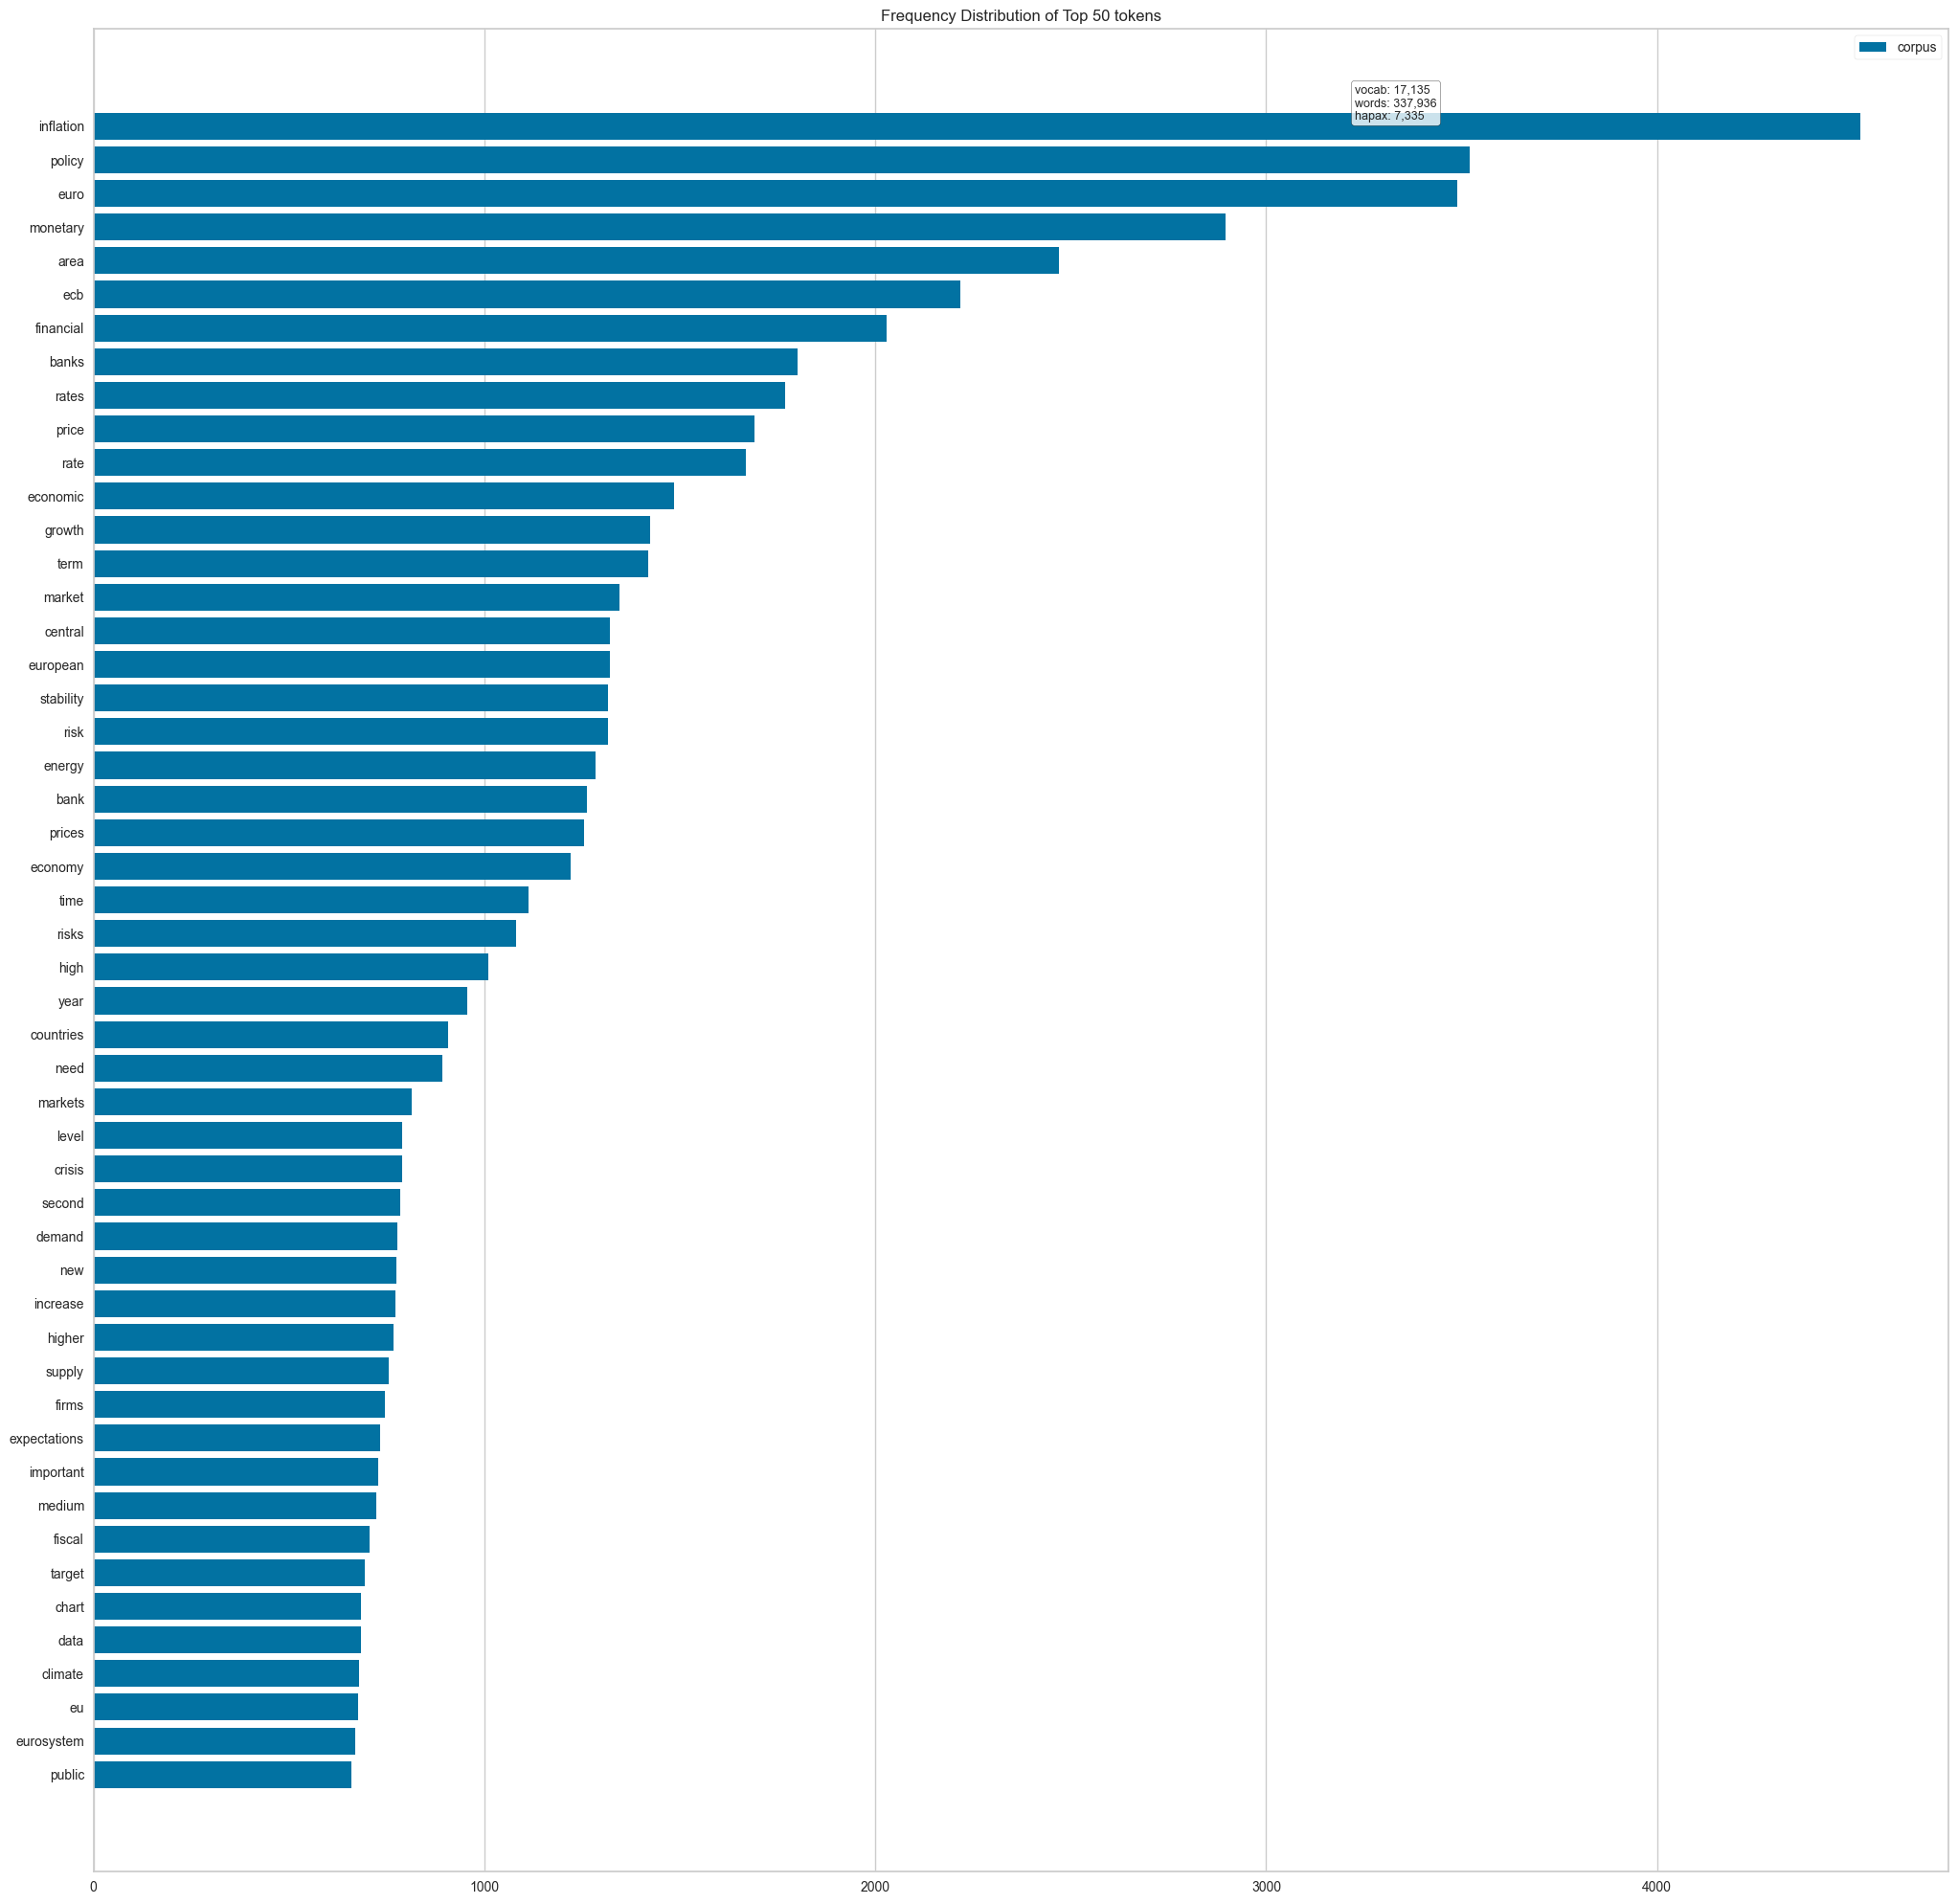

In [39]:
freq_distribution(direction_increase_df['extracted_text'].astype(str))

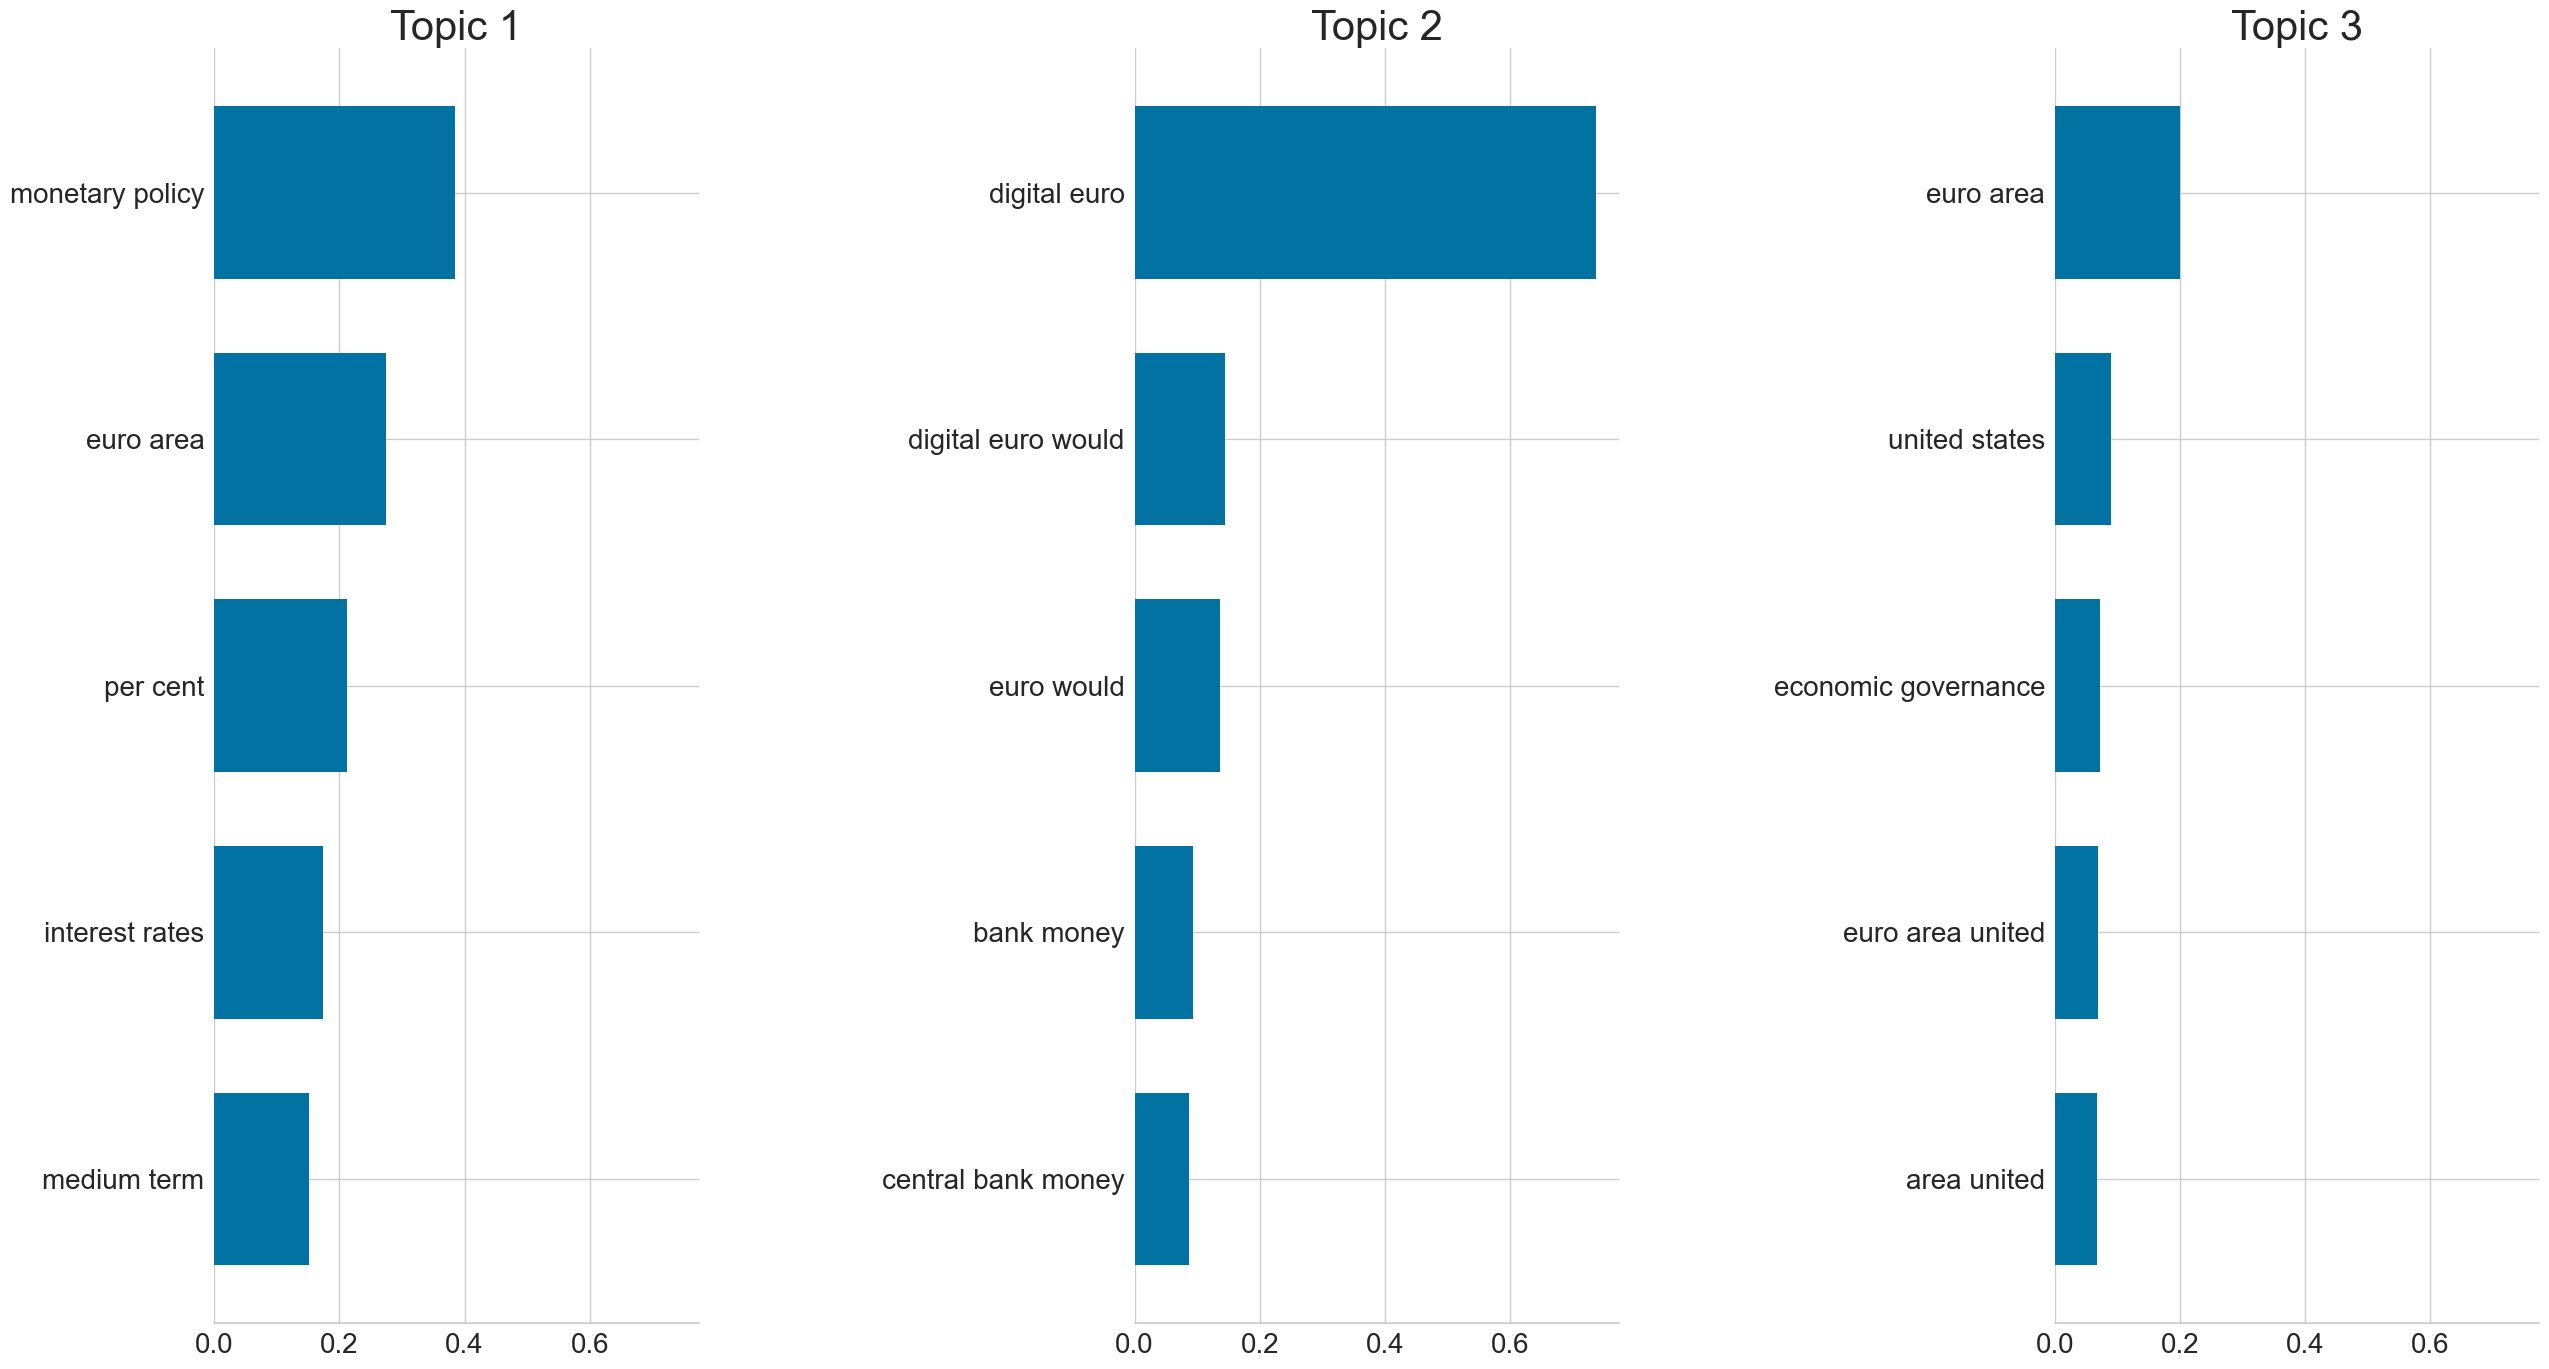

In [40]:
NMF_fit(direction_increase_df['extracted_text'].astype(str))

/opt/miniconda3/lib/python3.12/site-packages/yellowbrick/base.py:258: DeprecationWarning: this method is deprecated, please use show() instead
  warnings.warn(


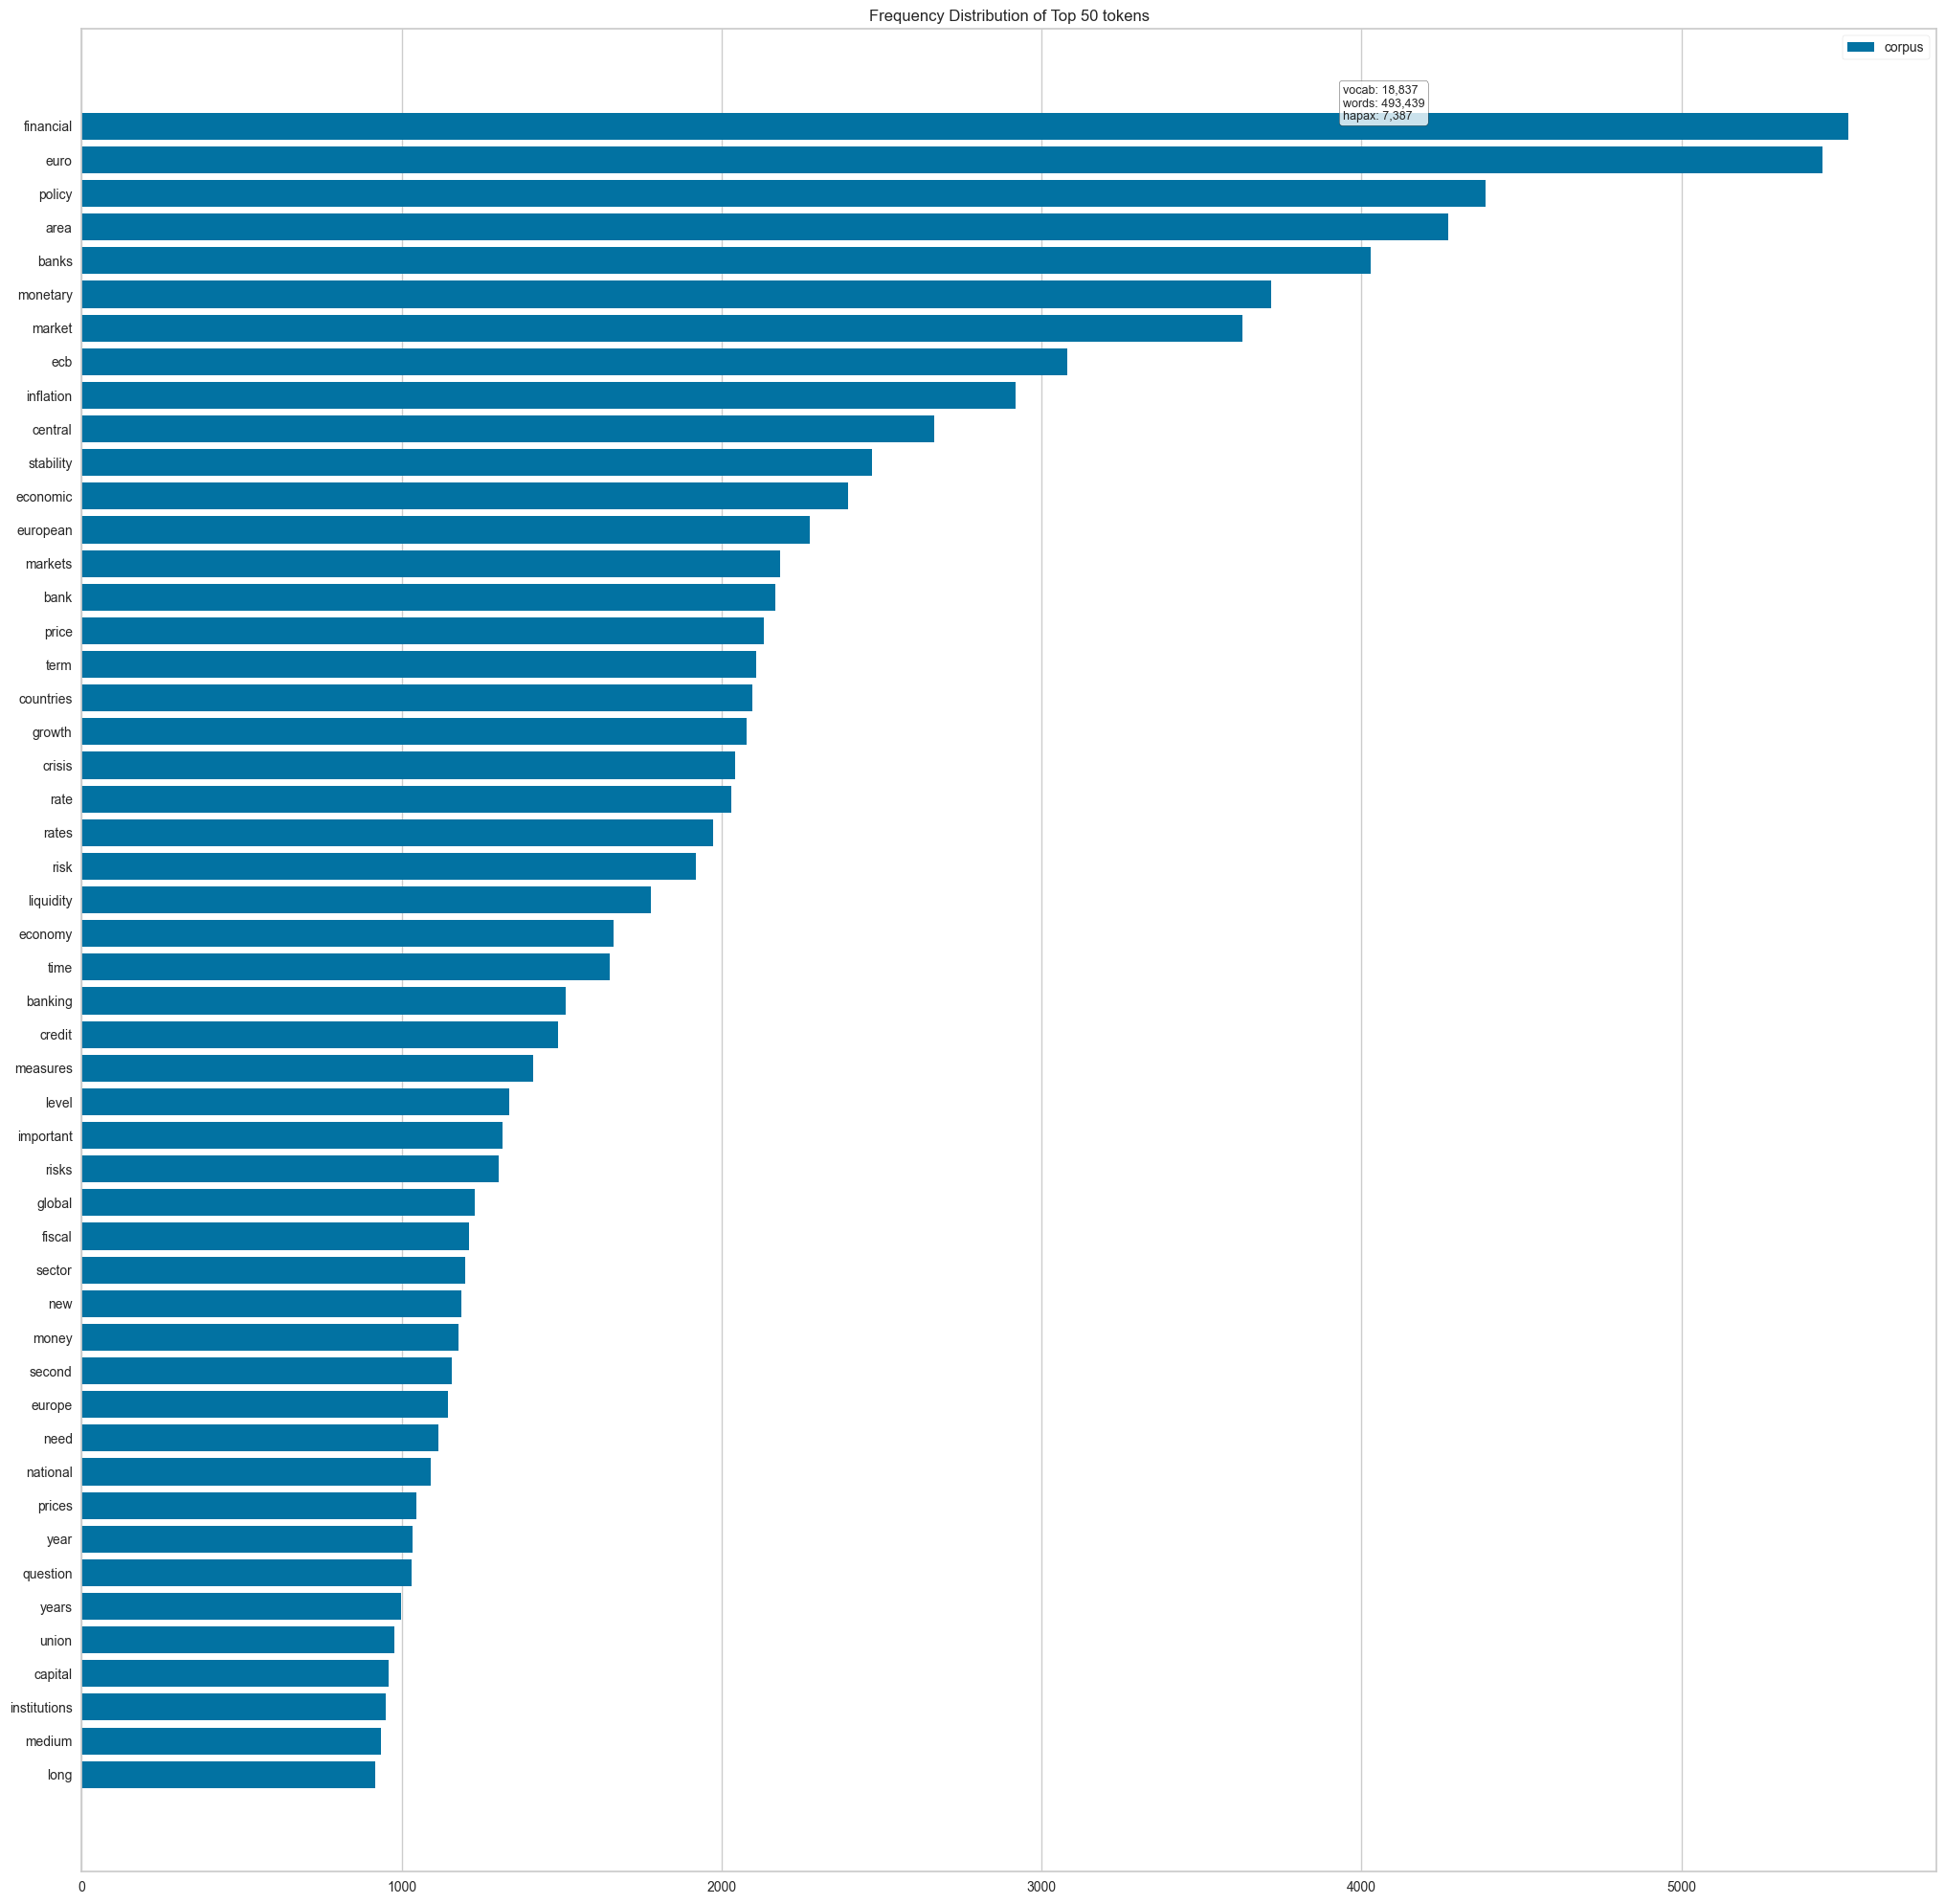

In [41]:
freq_distribution(direction_decrease_df['extracted_text'].astype(str))

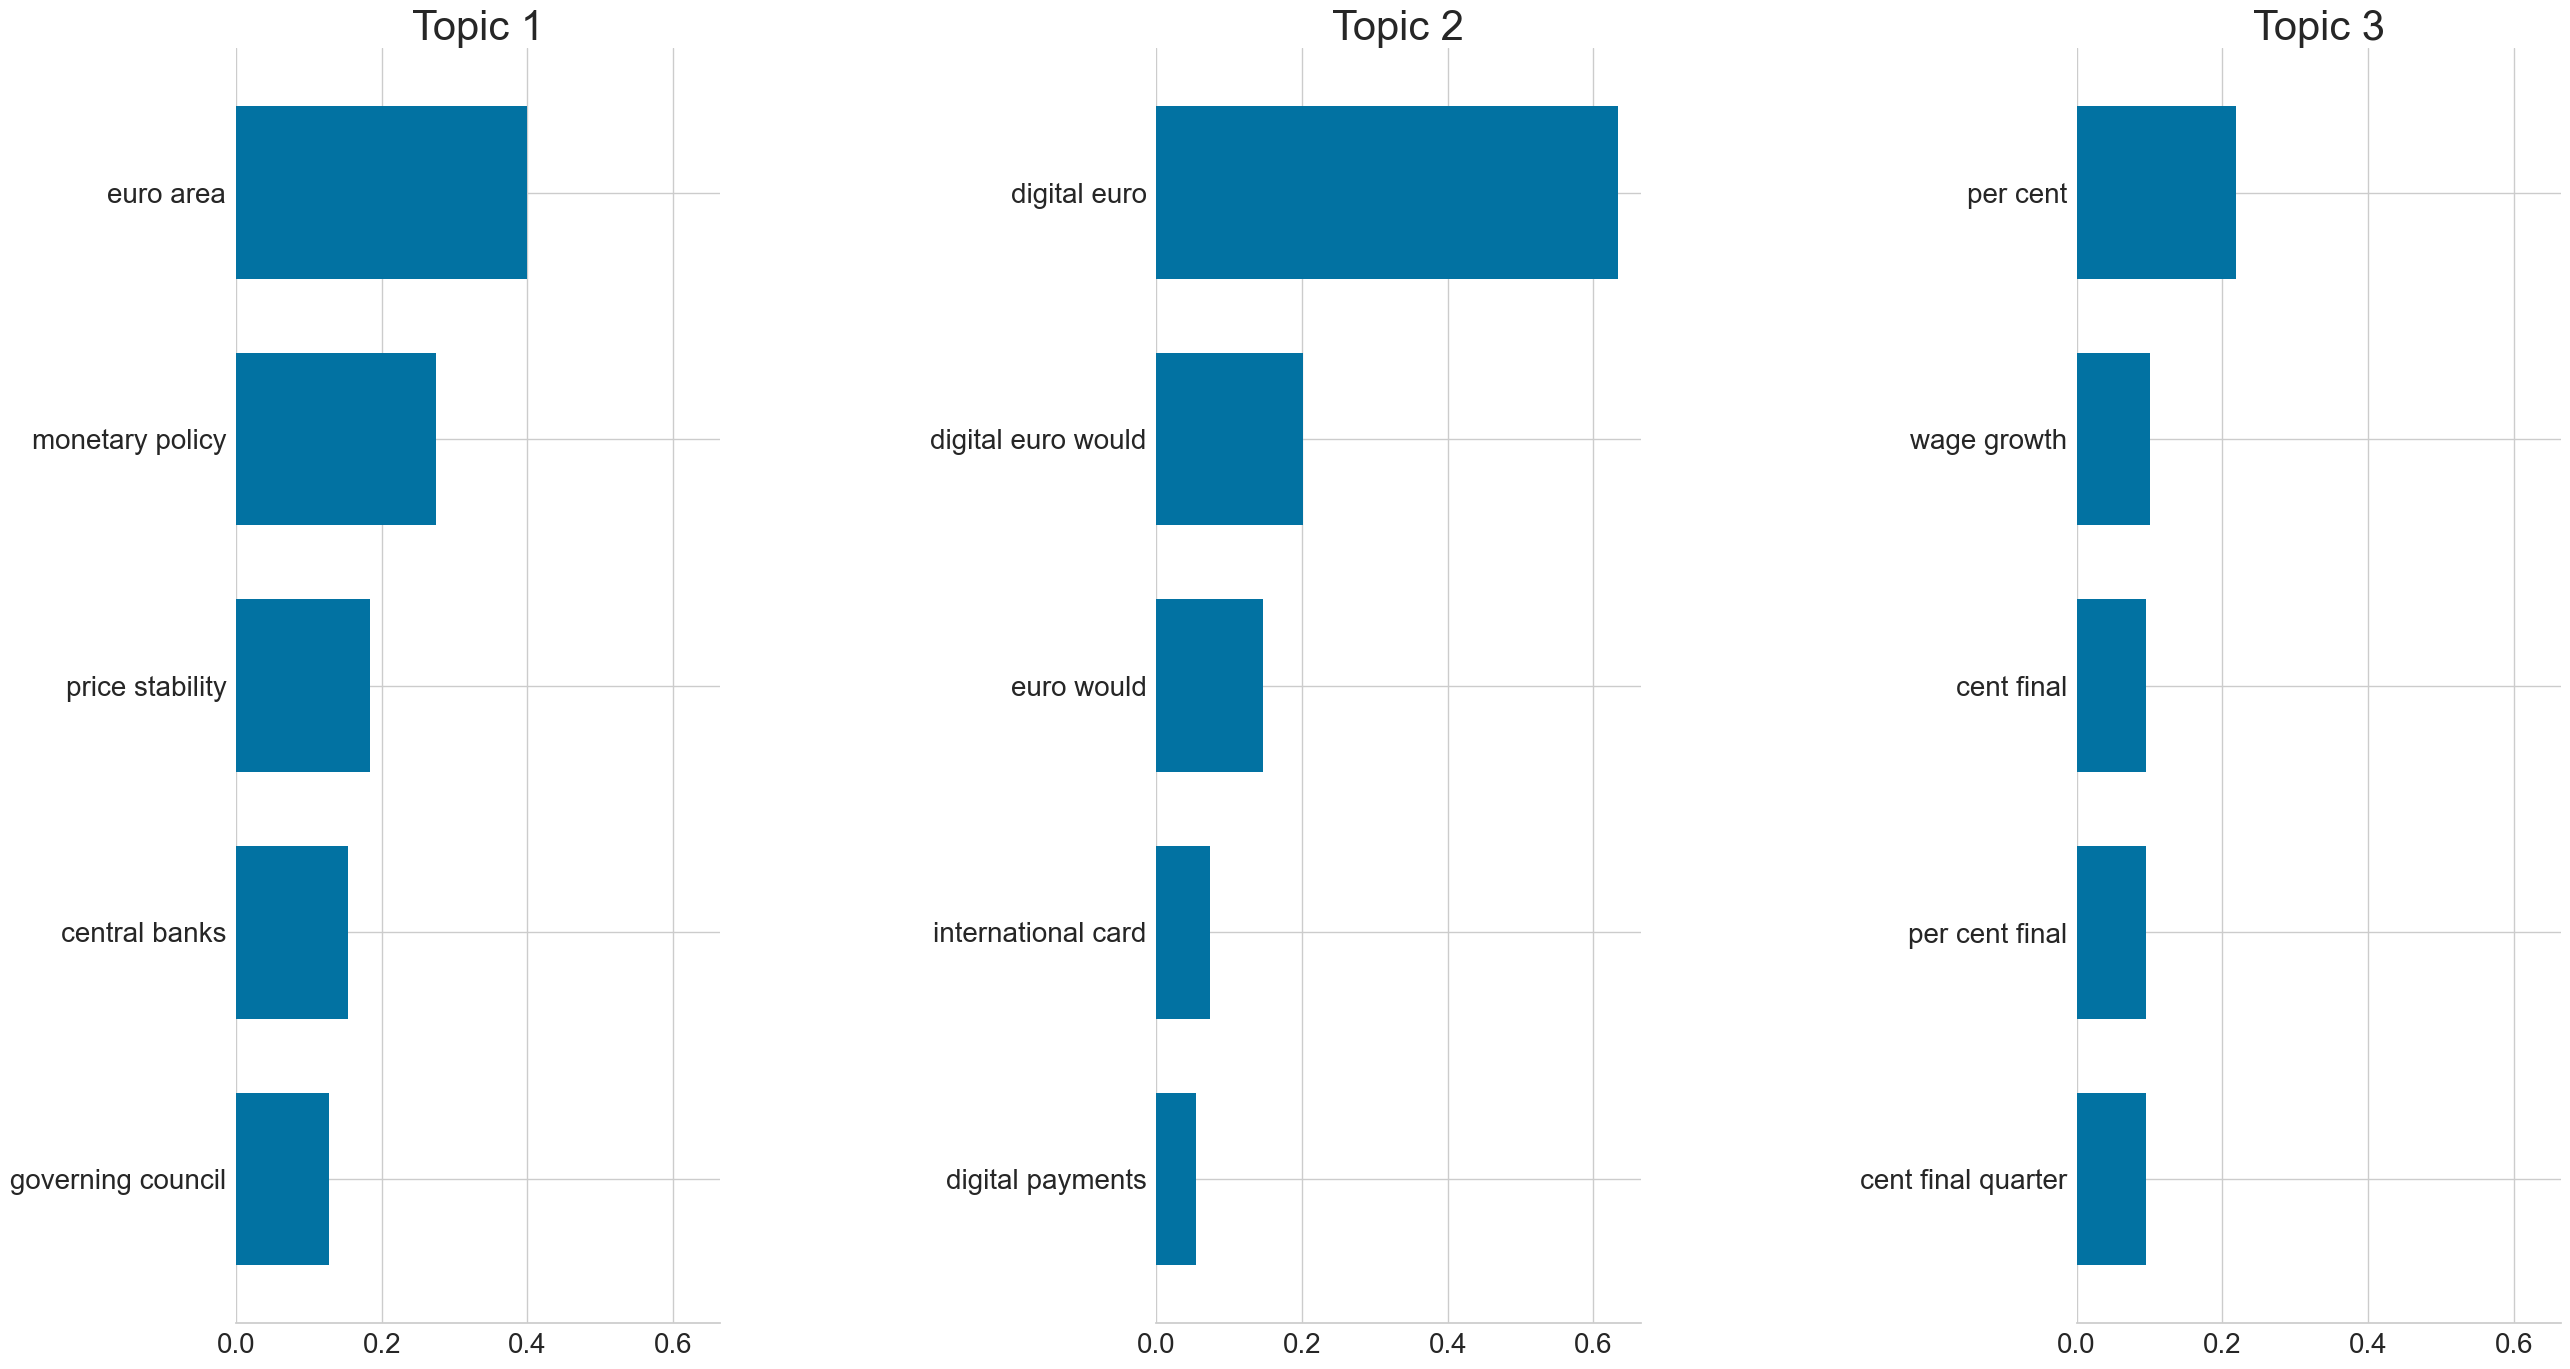

In [42]:
NMF_fit(direction_decrease_df['extracted_text'].astype(str))

## BERT Model

In [43]:
X = joined['extracted_text']
y = joined['Direction']

In [44]:
label_mapping = {
    'No Change': 0,
    'Increase': 1,
    'Decrease': 2
}

y_labels = y.map(label_mapping).values
y_labels

array([0, 2, 2, ..., 2, 2, 2])

In [45]:
print("y:\n", y.value_counts())
print()
print("y_labels:\n", pd.Series(y_labels).value_counts())

y:
 Direction
No Change    2888
Decrease      294
Increase      252
Name: count, dtype: int64

y_labels:
 0    2888
2     294
1     252
Name: count, dtype: int64


In [46]:
%%time
import logging
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, RandomSampler, TensorDataset, SequentialSampler
from transformers import AdamW
from sklearn.metrics import accuracy_score

logging.basicConfig(level=logging.INFO)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

X_text = [" ".join(doc) for doc in X]

# lists to store results
input_ids_list = []
attention_masks_list = []

batch_size = 100 

# process the data in batches
with tqdm(total=len(X_text), desc="Tokenizing", unit="doc") as pbar:
    for i in range(0, len(X_text), batch_size):
        batch_texts = X_text[i:i + batch_size]
        
        encoded_batch = tokenizer.batch_encode_plus(
            batch_texts,
            add_special_tokens=True,
            return_attention_mask=True,
            padding='max_length',
            max_length=256,
            truncation=True,
            return_tensors='pt'
        )
        
        input_ids_list.append(encoded_batch['input_ids'])
        attention_masks_list.append(encoded_batch['attention_mask'])
        
        pbar.update(len(batch_texts))

# concatenate all batches into tensors
input_ids_train = torch.cat(input_ids_list, dim=0)
attention_masks_train = torch.cat(attention_masks_list, dim=0)

# convert labels to tensor
labels_train = torch.tensor(y_labels)

Tokenizing: 100%|██████████████████████████| 3434/3434 [02:29<00:00, 22.90doc/s]

CPU times: user 2min 30s, sys: 957 ms, total: 2min 31s
Wall time: 2min 36s


In [47]:
from sklearn.model_selection import train_test_split

# create tensors
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)

# train/test split
train_dataset, test_dataset = train_test_split(dataset_train, test_size=0.2, stratify=y, random_state=42)

batch_size = 32

# load training data
dataloader_train = DataLoader(train_dataset, 
                              sampler=RandomSampler(train_dataset), 
                              batch_size=batch_size)

# load test/validation data
dataloader_test = DataLoader(test_dataset, 
                              sampler=RandomSampler(test_dataset), 
                              batch_size=batch_size)

In [48]:
from sklearn.utils.class_weight import compute_class_weight

# calculate class weights for imbalanced dataset
class_weights = compute_class_weight('balanced', classes=np.unique(y_labels), y=y_labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

print(f"Class Weights: {class_weights}")

Class Weights: [0.39635272 4.54232804 3.89342404]


In [49]:
# create model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                      num_labels=3,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

# set model optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, eps=1e-8)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [50]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# add weighted loss function to device
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights_tensor.to(device))
loss_fn.to(device)

CrossEntropyLoss()

In [51]:
# functions to calculate f1 score and accuracy

from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [52]:
# create function to evaluate performance against test/validation dataset
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [53]:
from transformers import get_linear_schedule_with_warmup

epochs = 10

# early stopping parameters
patience = 2  
best_val_loss = np.inf
early_stopping_counter = 0

# learning rate scheduler that linearly decreases learning rate
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

# training loop
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)             
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_test)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

    # early stopping and save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), 'best_bert_model.model')
        tqdm.write(f'Validation loss improved, saving model.')
    else:
        early_stopping_counter += 1
        tqdm.write(f'No improvement in validation loss for {early_stopping_counter} epochs.')

    if early_stopping_counter >= patience:
        tqdm.write(f'\nEarly stopping after {epoch} epochs.')
        break

  0%|                                                    | 0/10 [12:48<?, ?it/s]


Epoch 1
Training loss: 0.5655723106722499


  0%|                                                    | 0/10 [13:17<?, ?it/s]

Validation loss: 0.5208350792527199
F1 Score (Weighted): 0.7849226361436812


 10%|████                                     | 1/10 [13:17<1:59:41, 797.95s/it]

Validation loss improved, saving model.



 10%|████                                     | 1/10 [26:05<1:59:41, 797.95s/it]


Epoch 2
Training loss: 0.5139379868673724


 10%|████                                     | 1/10 [26:33<1:59:41, 797.95s/it]

Validation loss: 0.51360230689699
F1 Score (Weighted): 0.7907670876962326


 20%|████████▏                                | 2/10 [26:33<1:46:13, 796.74s/it]

Validation loss improved, saving model.



 20%|████████▏                                | 2/10 [39:15<1:46:13, 796.74s/it]


Epoch 3
Training loss: 0.46685537349346073


 20%|████████▏                                | 2/10 [39:43<1:46:13, 796.74s/it]

Validation loss: 0.49907695163380017
F1 Score (Weighted): 0.8007398829623605


 30%|████████████▎                            | 3/10 [39:44<1:32:36, 793.74s/it]

Validation loss improved, saving model.



 30%|████████████▎                            | 3/10 [51:40<1:32:36, 793.74s/it]


Epoch 4
Training loss: 0.44616582608500194


 30%|████████████▎                            | 3/10 [52:07<1:32:36, 793.74s/it]

Validation loss: 0.49167648364197125
F1 Score (Weighted): 0.803305827689342


 40%|████████████████▍                        | 4/10 [52:07<1:17:23, 774.00s/it]

Validation loss improved, saving model.



 40%|███████████████▌                       | 4/10 [1:03:47<1:17:23, 774.00s/it]


Epoch 5
Training loss: 0.4379677947523982


 40%|███████████████▌                       | 4/10 [1:04:15<1:17:23, 774.00s/it]

Validation loss: 0.44893674891103397
F1 Score (Weighted): 0.8112287231289681


 50%|███████████████████▌                   | 5/10 [1:04:15<1:03:07, 757.50s/it]

Validation loss improved, saving model.



 50%|███████████████████▌                   | 5/10 [1:14:55<1:03:07, 757.50s/it]


Epoch 6
Training loss: 0.4118476806338443


 50%|███████████████████▌                   | 5/10 [1:15:22<1:03:07, 757.50s/it]

Validation loss: 0.4341384013268081
F1 Score (Weighted): 0.8166169047732947


 60%|████████████████████████▌                | 6/10 [1:15:22<48:26, 726.69s/it]

Validation loss improved, saving model.



 60%|████████████████████████▌                | 6/10 [1:24:56<48:26, 726.69s/it]


Epoch 7
Training loss: 0.3927688667940539


 60%|████████████████████████▌                | 6/10 [1:25:22<48:26, 726.69s/it]

Validation loss: 0.41700610518455505
F1 Score (Weighted): 0.8140661316543393


 70%|████████████████████████████▋            | 7/10 [1:25:23<34:16, 685.46s/it]

Validation loss improved, saving model.



 70%|████████████████████████████▋            | 7/10 [1:35:06<34:16, 685.46s/it]


Epoch 8
Training loss: 0.37110998013684915


 70%|████████████████████████████▋            | 7/10 [1:35:32<34:16, 685.46s/it]

Validation loss: 0.40490243109789764
F1 Score (Weighted): 0.8149963498019429


 80%|████████████████████████████████▊        | 8/10 [1:35:33<22:02, 661.31s/it]

Validation loss improved, saving model.



 80%|████████████████████████████████▊        | 8/10 [1:45:25<22:02, 661.31s/it]


Epoch 9
Training loss: 0.3634908227033393


 80%|████████████████████████████████▊        | 8/10 [1:45:51<22:02, 661.31s/it]

Validation loss: 0.39414035190235486
F1 Score (Weighted): 0.8149963498019429


 90%|████████████████████████████████████▉    | 9/10 [1:45:52<10:48, 648.13s/it]

Validation loss improved, saving model.



 90%|████████████████████████████████████▉    | 9/10 [1:55:58<10:48, 648.13s/it]


Epoch 10
Training loss: 0.350430648167466


100%|████████████████████████████████████████| 10/10 [1:56:24<00:00, 698.49s/it]

Validation loss: 0.39495991983196954
F1 Score (Weighted): 0.8189760923176829
No improvement in validation loss for 1 epochs.


In [55]:
from sklearn.metrics import classification_report

# Load the trained model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
model.load_state_dict(torch.load('best_bert_model.model')) #'finetuned_BERT_epoch_10.model'
model.to(device)

# Ensure the model is in evaluation mode
model.eval()

# Evaluate on the test set
val_loss = 0
predictions, true_vals = [], []

with torch.no_grad():
    for batch in tqdm(dataloader_test, desc='Evaluating', leave=False):
        batch = tuple(b.to(device) for b in batch)

        inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
            'labels': batch[2],
        }

        outputs = model(**inputs)

        loss = outputs[0]
        val_loss += loss.item()

        logits = outputs[1]
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        true = inputs['labels'].cpu().numpy()

        predictions.extend(preds)
        true_vals.extend(true)

# Calculate average validation loss
val_loss_avg = val_loss / len(dataloader_test)
print(f'Validation loss: {val_loss_avg:.3f}')

# Calculate accuracy
val_accuracy = accuracy_score(true_vals, predictions)
print(f'Accuracy: {val_accuracy:.2f}')

# Generate classification report
report = classification_report(true_vals, predictions, target_names=['No Change', 'Increase', 'Decrease'])
print('\nClassification Report:')
print(report)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/9m/7yp5ccpj2l77_fc7h4k3ldrr0000gn/T/ipykernel_1415/4027518696.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `

Validation loss: 0.403
Accuracy: 0.85

Classification Report:
              precision    recall  f1-score   support

   No Change       0.88      0.96      0.92       578
    Increase       0.57      0.64      0.60        50
    Decrease       0.00      0.00      0.00        59

    accuracy                           0.85       687
   macro avg       0.48      0.53      0.51       687
weighted avg       0.78      0.85      0.81       687



/opt/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


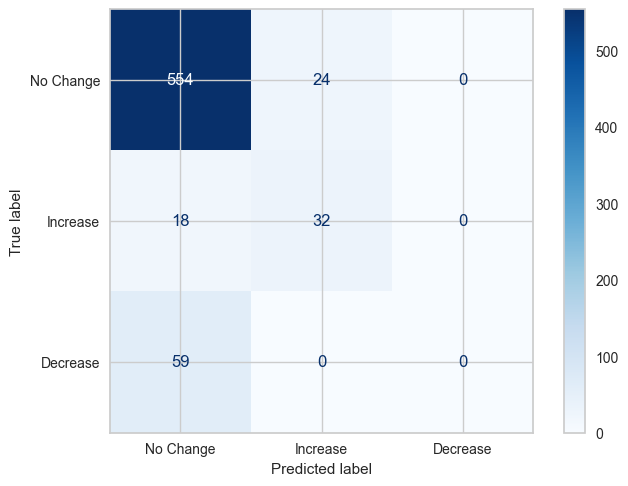

In [57]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(true_vals, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Change', 'Increase', 'Decrease'])
disp.plot(cmap='Blues')
plt.show()

In [59]:
print(predictions)

[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 

### Resume Training

In [61]:
import torch
from transformers import get_linear_schedule_with_warmup, BertForSequenceClassification, AdamW

# reload the model architecture
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

# lead best saved model
model.load_state_dict(torch.load('best_model.model'))
model.to(device)

class_weights = compute_class_weight('balanced', classes=np.unique(y_labels), y=y_labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)

optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)

# additional training epochs
additional_epochs = 50

scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=0,
    num_training_steps=len(dataloader_train) * additional_epochs
)

patience = 2  
best_val_loss = np.inf
early_stopping_counter = 0

for epoch in tqdm(range(1, additional_epochs + 1)):
    
    model.train()
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})

    torch.save(model.state_dict(), f'finetuned_BERT_epoch_{epoch + 10}.model')
        
    tqdm.write(f'\nEpoch {epoch + 10}')  # Continuing from the 10th epoch
    
    loss_train_avg = loss_train_total / len(dataloader_train)             
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_test)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), 'best_bert_model.model')
        tqdm.write(f'Validation loss improved, saving model.')
    else:
        early_stopping_counter += 1
        tqdm.write(f'No improvement in validation loss for {early_stopping_counter} epochs.')

    if early_stopping_counter >= patience:
        tqdm.write(f'\nEarly stopping after {epoch + 10} epochs.')
        break

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/9m/7yp5ccpj2l77_fc7h4k3ldrr0000gn/T/ipykernel_1415/2232265380.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `


Epoch 11
Training loss: 0.38365491254385126


  0%|                                                    | 0/50 [12:01<?, ?it/s]

Validation loss: 0.38849287751046097
F1 Score (Weighted): 0.8358642357864565


  2%|▊                                        | 1/50 [12:02<9:50:16, 722.80s/it]

Validation loss improved, saving model.



  2%|▊                                        | 1/50 [23:35<9:50:16, 722.80s/it]


Epoch 12
Training loss: 0.3437229328204033


  2%|▊                                        | 1/50 [24:02<9:50:16, 722.80s/it]

Validation loss: 0.3496891751208089
F1 Score (Weighted): 0.8232271287750405


  4%|█▋                                       | 2/50 [24:03<9:37:24, 721.75s/it]

Validation loss improved, saving model.



  4%|█▋                                       | 2/50 [35:30<9:37:24, 721.75s/it]


Epoch 13
Training loss: 0.3202389665814333


  6%|██▍                                      | 3/50 [35:57<9:22:23, 717.95s/it]

Validation loss: 0.35894788192077115
F1 Score (Weighted): 0.8509869930763448
No improvement in validation loss for 1 epochs.



  6%|██▍                                      | 3/50 [47:28<9:22:23, 717.95s/it]


Epoch 14
Training loss: 0.29019672908755234


  6%|██▍                                     | 3/50 [47:55<12:30:46, 958.44s/it]

Validation loss: 0.3506931466135112
F1 Score (Weighted): 0.8592694761505567
No improvement in validation loss for 2 epochs.

Early stopping after 14 epochs.


In [62]:
# Load the trained model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
model.load_state_dict(torch.load('best_bert_model.model'))
model.to(device)

# Ensure the model is in evaluation mode
model.eval()

# Evaluate on the test set
val_loss = 0
predictions, true_vals = [], []

with torch.no_grad():
    for batch in tqdm(dataloader_test, desc='Evaluating', leave=False):
        batch = tuple(b.to(device) for b in batch)

        inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
            'labels': batch[2],
        }

        outputs = model(**inputs)

        loss = outputs[0]
        val_loss += loss.item()

        logits = outputs[1]
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        true = inputs['labels'].cpu().numpy()

        predictions.extend(preds)
        true_vals.extend(true)

# Calculate average validation loss
val_loss_avg = val_loss / len(dataloader_test)
print(f'Validation loss: {val_loss_avg:.3f}')

# Calculate accuracy
val_accuracy = accuracy_score(true_vals, predictions)
print(f'Accuracy: {val_accuracy:.2f}')

# Generate classification report
report = classification_report(true_vals, predictions, target_names=['No Change', 'Increase', 'Decrease'])
print('\nClassification Report:')
print(report)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/9m/7yp5ccpj2l77_fc7h4k3ldrr0000gn/T/ipykernel_1415/1319230658.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `

Validation loss: 0.363
Accuracy: 0.86

Classification Report:
              precision    recall  f1-score   support

   No Change       0.88      0.97      0.92       578
    Increase       0.62      0.64      0.63        50
    Decrease       1.00      0.02      0.03        59

    accuracy                           0.86       687
   macro avg       0.83      0.54      0.53       687
weighted avg       0.87      0.86      0.82       687



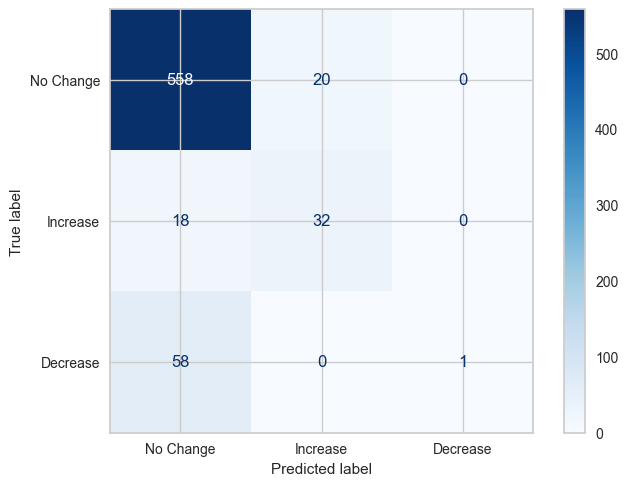

In [64]:
cm = confusion_matrix(true_vals, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Change', 'Increase', 'Decrease'])
disp.plot(cmap='Blues')
plt.show()